## E-commerce Data Analysis
The next chapter covers the detection of outliers, the data analysis in general to get an insight of meaningful data about the orders and the user behaviour. The last section classifies the features in sequence related to the strength of their relation or correlation to the review score. This information should indicate which features probably generate the highest impact to the model when predicting the target value.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)
sns.set_style('whitegrid')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

pd.set_option('display.max_columns', None)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df = pd.read_csv('../resources/Brazilian_retail/ecommerce_model1.csv',
                 lineterminator='\n',
                 parse_dates=['order_estimated_delivery_date', 'order_purchase_date', 
                              'review_creation_date', 'shipping_limit_date'])

In [3]:
df.head()

order_id                       customer_id  \
0  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
1  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
2  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
3  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
4  a4591c265e18cb1dcee52889e2d8acc3  503740e9ca751ccdda7ba28e9ab8f608   

  order_estimated_delivery_date                customer_unique_id  \
0                    2018-08-13  af07308b275d755c9edb36a90c618231   
1                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
2                    2017-12-15  7c142cf63193a1473d2e66489a9ae977   
3                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   
4                    2017-08-01  80bb27c7c16e8f973207a5086ab329e2   

   customer_zip_code_prefix            customer_city customer_state  \
0                     47813                barreiras             BA   
1                     75265               vianopolis             GO   
2                     59296  sao goncalo do amarante             RN   
3                      9195              santo andre             SP   
4                     86320             congonhinhas             PR   

   geolocation_lat_customer  geolocation_lng_customer  \
0                -12.169860                -44.988369   
1                -16.746337                -48.514624   
2                 -5.767733                -35.275467   
3                -23.675037                -46.524784   
4                -23.548581                -50.550660   

                          review_id  review_score  \
0  8d5266042046a06655c8db133d120ba5             4   
1  e73b67b67587f7644d5bd1a52deb1b01             5   
2  359d03e676b3c069f62cadba8dd3f6e8             5   
3  e50934924e227544ba8246aeb3770dd4             5   
4  89b738e70a1ce346db29a20fb2910161             4   

                              review_comment_message review_creation_date  \
0                               Muito bom o produto.           2018-08-08   
1                                         no_message           2018-08-18   
2  O produto foi exatamente o que eu esperava e e...           2017-12-03   
3                                         no_message           2018-02-17   
4                                         no_message           2017-07-27   

   payment_sequential payment_type  payment_installments  payment_value  \
0                   1       boleto                     1         141.46   
1                   1  credit_card                     3         179.12   
2                   1  credit_card                     1          72.20   
3                   1  credit_card                     1          28.62   
4                   1  credit_card                     6         175.26   

   order_item                        product_id  \
0           1  595fac2a385ac33a80bd5114aec74eb8   
1           1  aa4383b373c6aca5d8797843e5594415   
2           1  d0b61bfb1de832b15ba9d266ca96e5b0   
3           1  65266b2da20d04dbe00c5c2d3bb7859e   
4           1  060cb19345d90064d1015407193c233d   

                          seller_id shipping_limit_date  price  freight_value  \
0  289cdb325fb7e7f891c38608bf9e0962          2018-07-30  118.7          22.76   
1  4869f7a5dfa277a7dca6462dcf3b52b2          2018-08-13  159.9          19.22   
2  66922902710d126a0e7d26b0e3805106          2017-11-23   45.0          27.20   
3  2c9e548be18521d1c43cde1c582c6de8          2018-02-19   19.9           8.72   
4  8581055ce74af1daba164fdbd55a40de          2017-07-13  147.9          27.36   

  product_category_name  product_name_lenght  product_description_lenght  \
0            perfumaria                   29                         178   
1            automotivo                   46                         232   
2              pet_shop                   59                         468   
3             papelaria                   38                         316

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100645 entries, 0 to 100644
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       100645 non-null  object        
 1   customer_id                    100645 non-null  object        
 2   order_estimated_delivery_date  100645 non-null  datetime64[ns]
 3   customer_unique_id             100645 non-null  object        
 4   customer_zip_code_prefix       100645 non-null  int64         
 5   customer_city                  100645 non-null  object        
 6   customer_state                 100645 non-null  object        
 7   geolocation_lat_customer       100645 non-null  float64       
 8   geolocation_lng_customer       100645 non-null  float64       
 9   review_id                      100645 non-null  object        
 10  review_score                   100645 non-null  int64         
 11  

### Outlier Detection
Instead of looking at each feature for the detection of outliers only a specific amount of features are taken into account which are assumed to have a direct impact on the review score from a logical perspective. The focus is set on `order_diff`, `price` and on `freight_value`.

In [5]:
# for Q-Q plots
import scipy.stats as stats

In [6]:
def diagnostic_plots(df, variable):
    """
    This function shows the histogram, the Q-Q plot and the boxplot of the passed in feature name.
    
    Parameters:
    df (DataFrame): DataFrame 
    varialbe (string): feature name of interest 
    """
    
    plt.figure(figsize=(15, 5))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    
    plt.tight_layout()
    plt.show()

In [7]:
def find_skewed_boundaries(df, variable, distance):
    """
    This function returns the upper and lower boundaries calculated with the IQR technique
    to find outliers. The distance parameter defines the range by using following equations:
    lower_boundary: Q1 - IQR * distance
    upper_boundary: Q3 + IQR * distance
    
    For strongly skewed distribution the distance value should be higher (e.g. 3).
    
    
    Parameters:
    df (DataFrame): DataFrame
    variable (string): feature name of interest
    distance (integer/float): 
    
    Returns:
    upper_boundary (float): 
    lower_boundary (float):
    """

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

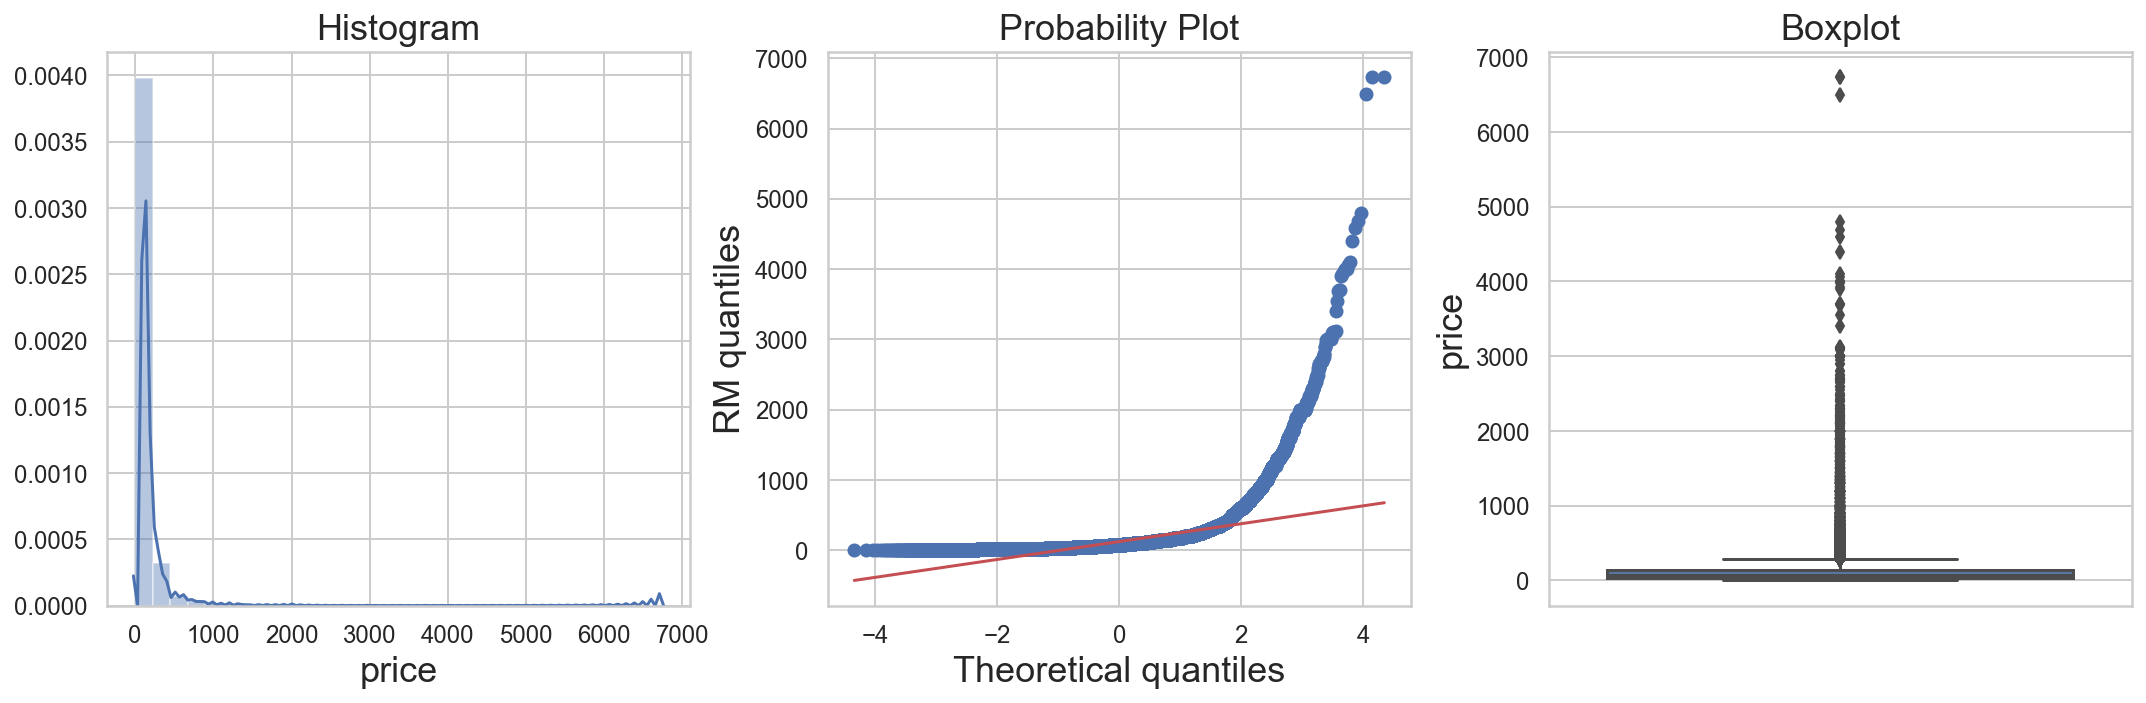

In [8]:
diagnostic_plots(df, 'price')

In [9]:
# distance argument of 3 due to strongly skewed distribution
price_upper_limit, price_lower_limit = find_skewed_boundaries(df, 'price', 3)
print("""Upper boundary: {up}
Lower boundary: {lw}
Prices over the upper boundary: {p}
% of prices over the upper boundary: {q}
""".format(up = price_upper_limit, 
           lw = price_lower_limit if price_lower_limit > 0 else 0,
           p = len(df[df['price'] > price_upper_limit]),
           q = round(len(df[df['price'] > price_upper_limit]) / len(df), 3)))

Upper boundary: 436.0
Lower boundary: 0
Prices over the upper boundary: 3643
% of prices over the upper boundary: 0.036



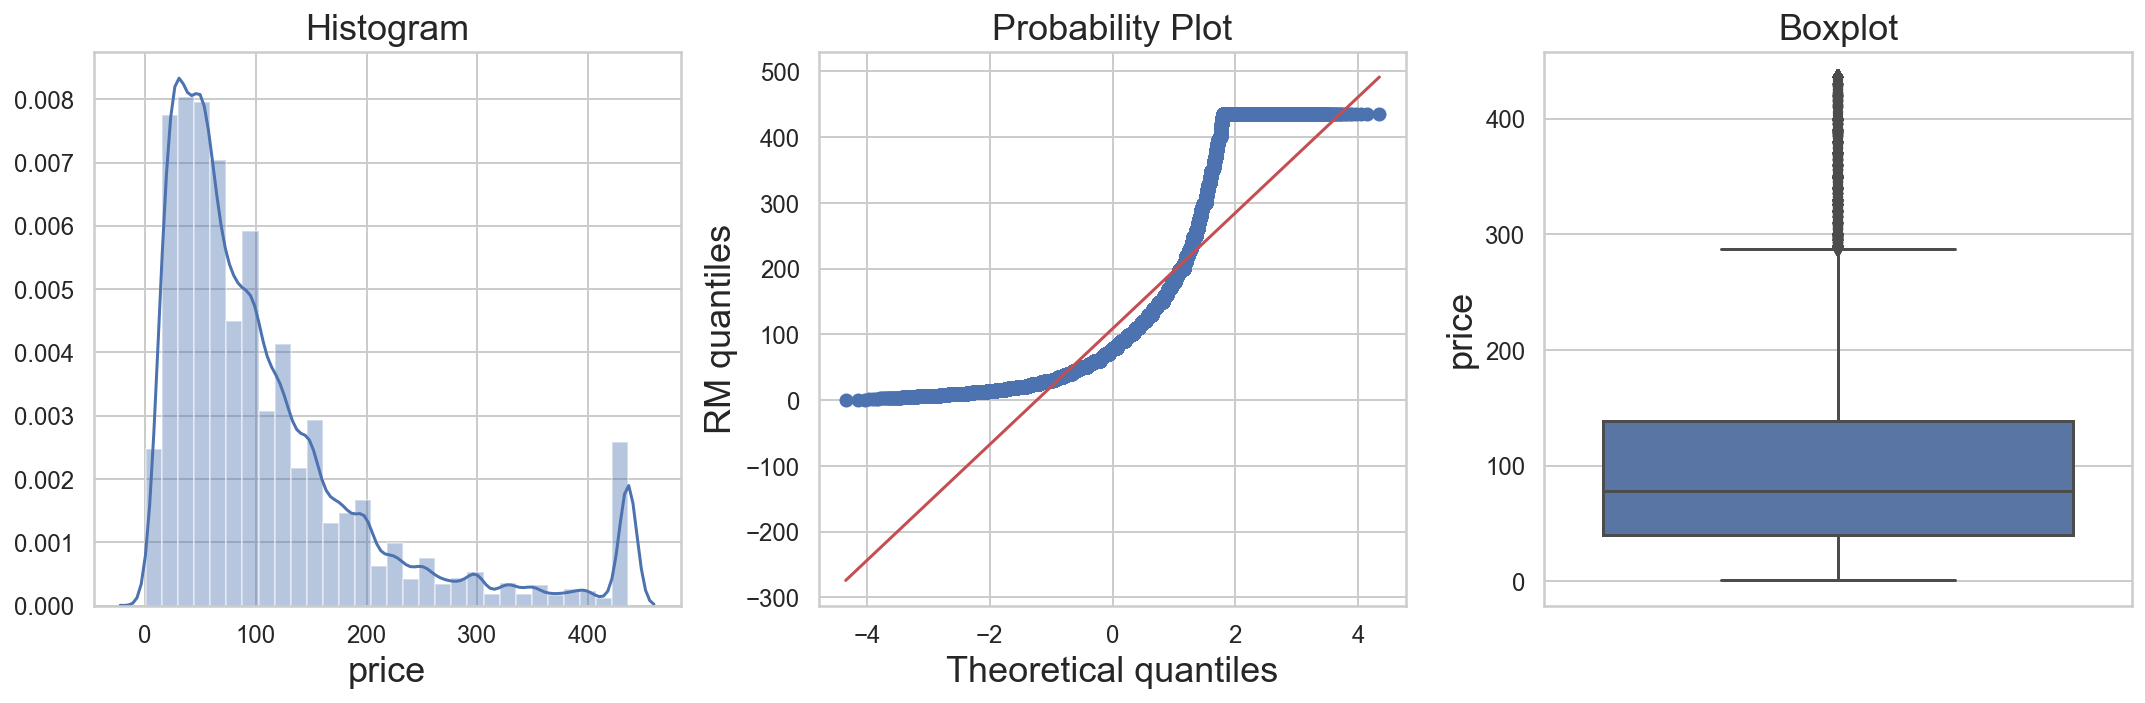

In [10]:
# limiting the price range with the outlier boundaries
payment_change_idx = df[df['price'] > price_upper_limit].index.tolist()

df['price'] = np.where(df['price'] > price_upper_limit, price_upper_limit, df['price'])

diagnostic_plots(df, 'price')

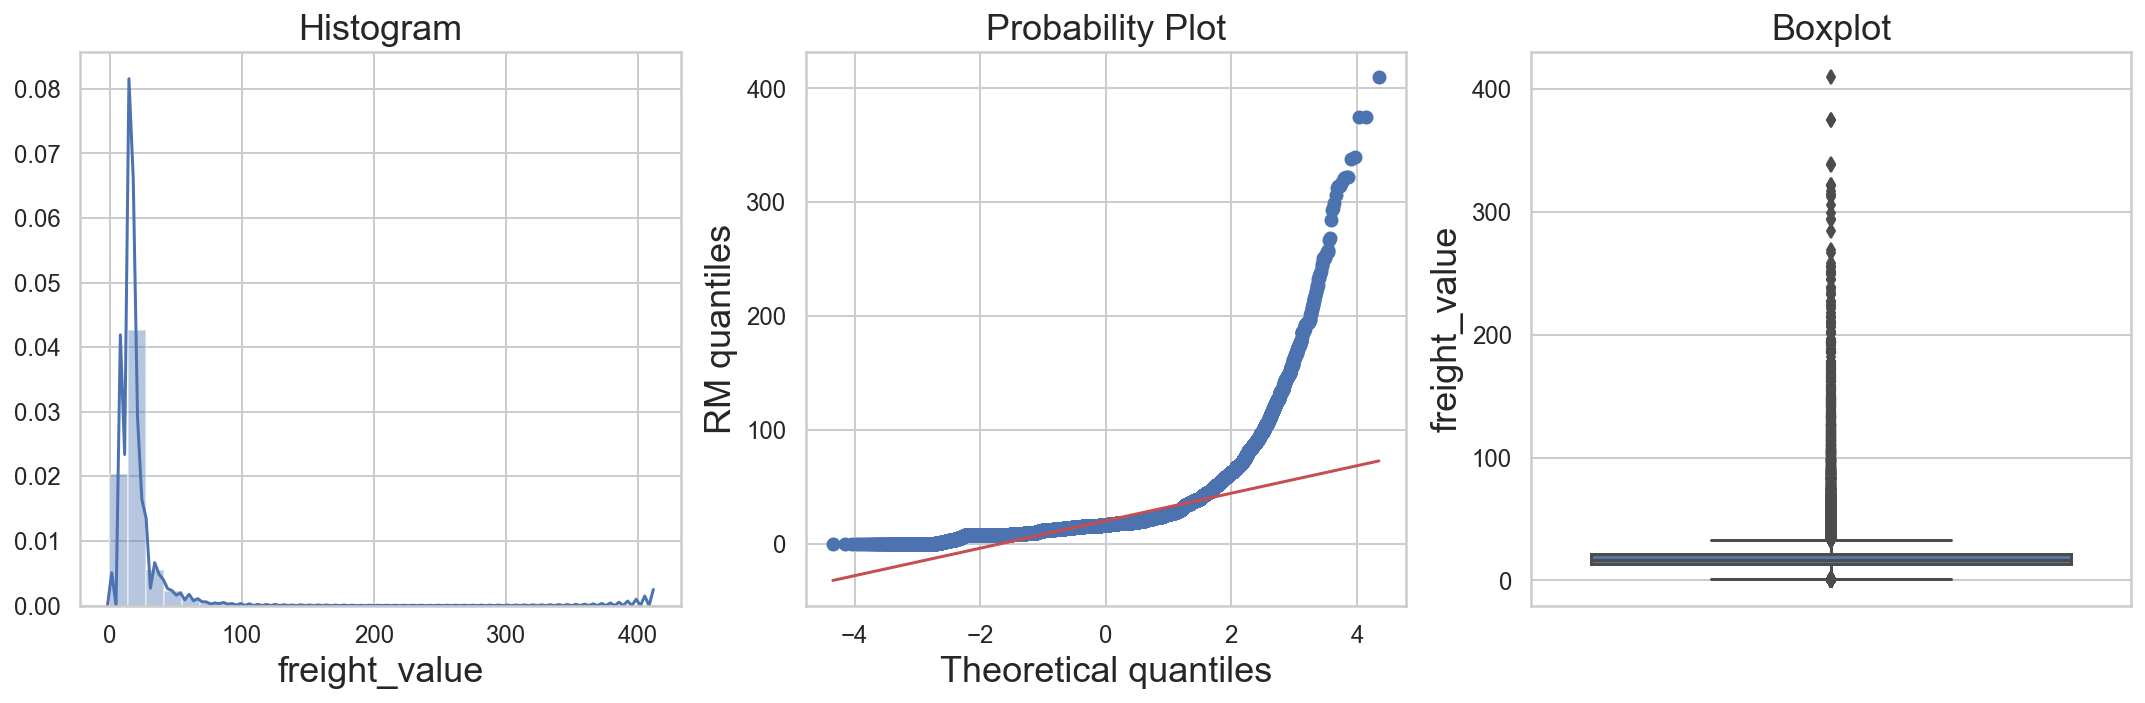

In [11]:
diagnostic_plots(df, 'freight_value')

In [12]:
freight_upper_limit, freight_lower_limit = find_skewed_boundaries(df, 'freight_value', 3)
print("""Upper boundary: {up}
Lower boundary: {lw}
Freight value over the upper boundary: {p}
% of freight values over the upper boundary: {q}
""".format(up = freight_upper_limit, 
           lw = freight_lower_limit if freight_lower_limit > 0 else 0,
           p = len(df[df['freight_value'] > freight_upper_limit]),
           q = round(len(df[df['freight_value'] > freight_upper_limit]) / len(df), 3)))

Upper boundary: 45.34
Lower boundary: 0
Freight value over the upper boundary: 5010
% of freight values over the upper boundary: 0.05



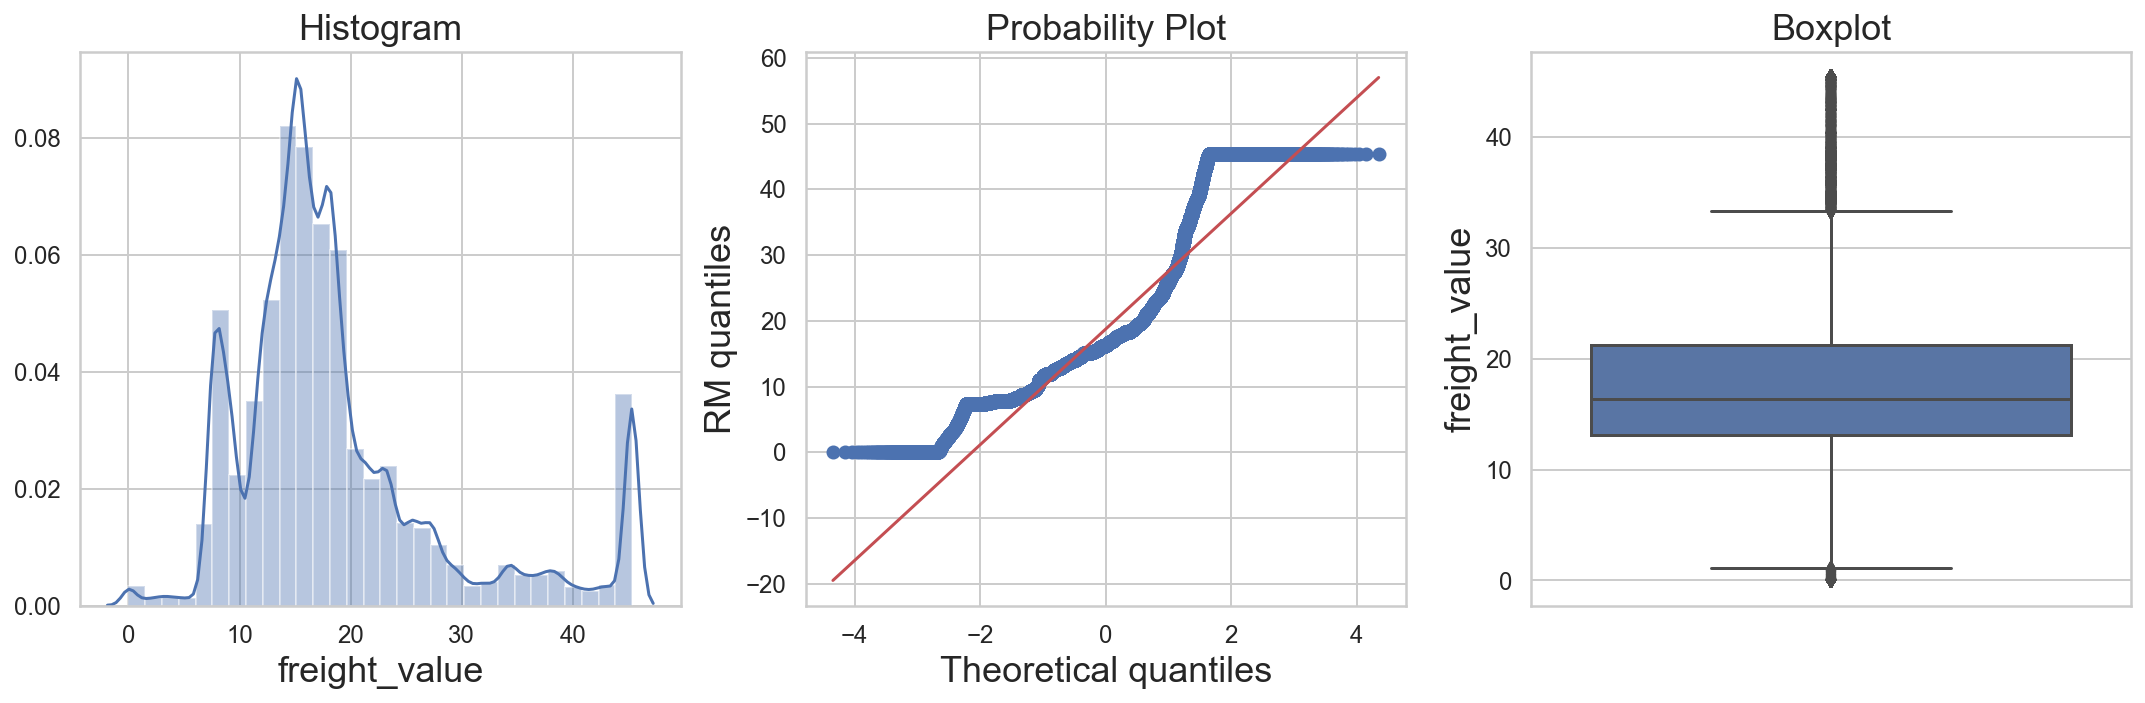

In [13]:
# limiting the freight_value range with the outlier boundaries
payment_change_idx.extend(df[df['freight_value'] > freight_upper_limit].index.tolist())
df['freight_value'] = np.where(df['freight_value'] > freight_upper_limit, freight_upper_limit, df['freight_value'])

diagnostic_plots(df, 'freight_value')

In [14]:
# payment_values are adjusted where price and/or freight_value have been changed
df.loc[payment_change_idx, 'payment_value'] = df.loc[payment_change_idx, ['price', 'freight_value']] \
                                                .apply(lambda x: round(x['price'] + x['freight_value'], 2),
                                                       axis=1)

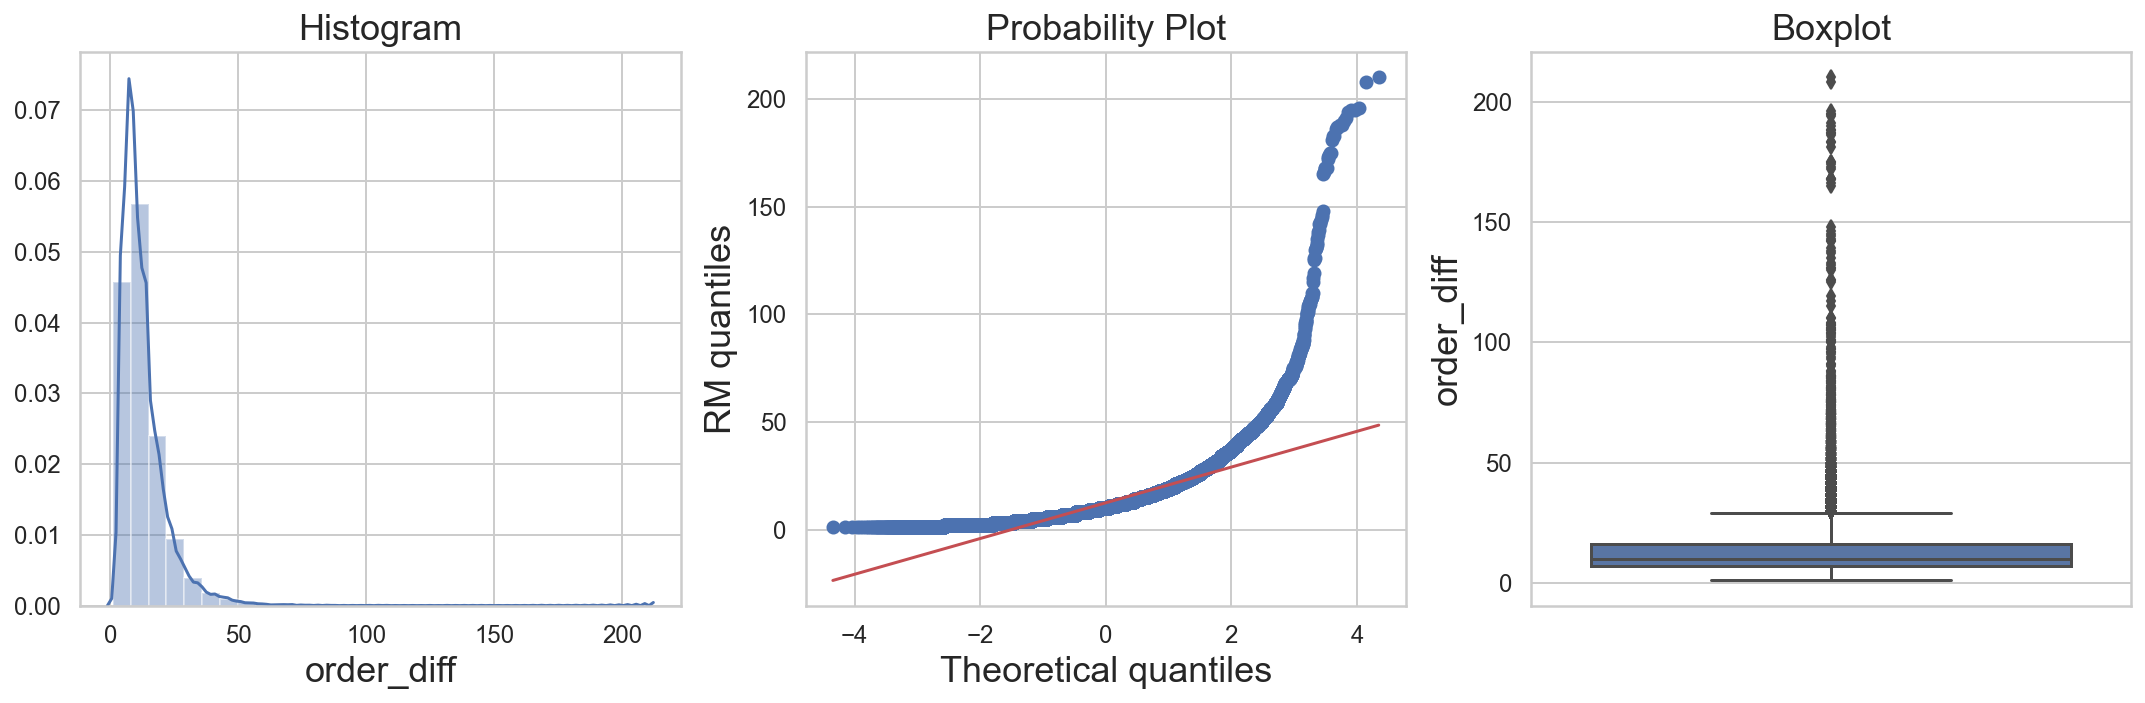

In [15]:
diagnostic_plots(df, 'order_diff')

In [16]:
order_diff_upper_limit, order_diff_lower_limit = find_skewed_boundaries(df, 'order_diff', 3)
print("""Upper boundary: {up}
Lower boundary: {lw}
Order deliveries over the upper boundary: {p}
% of order deliveries over the upper boundary: {q}
""".format(up = order_diff_upper_limit,
           lw = order_diff_lower_limit if order_diff_lower_limit > 0 else 0, 
           p = len(df[df['order_diff'] > order_diff_upper_limit]),
           q = round(len(df[df['order_diff'] > order_diff_upper_limit]) / len(df), 3)))

Upper boundary: 43.0
Lower boundary: 0
Order deliveries over the upper boundary: 1283
% of order deliveries over the upper boundary: 0.013



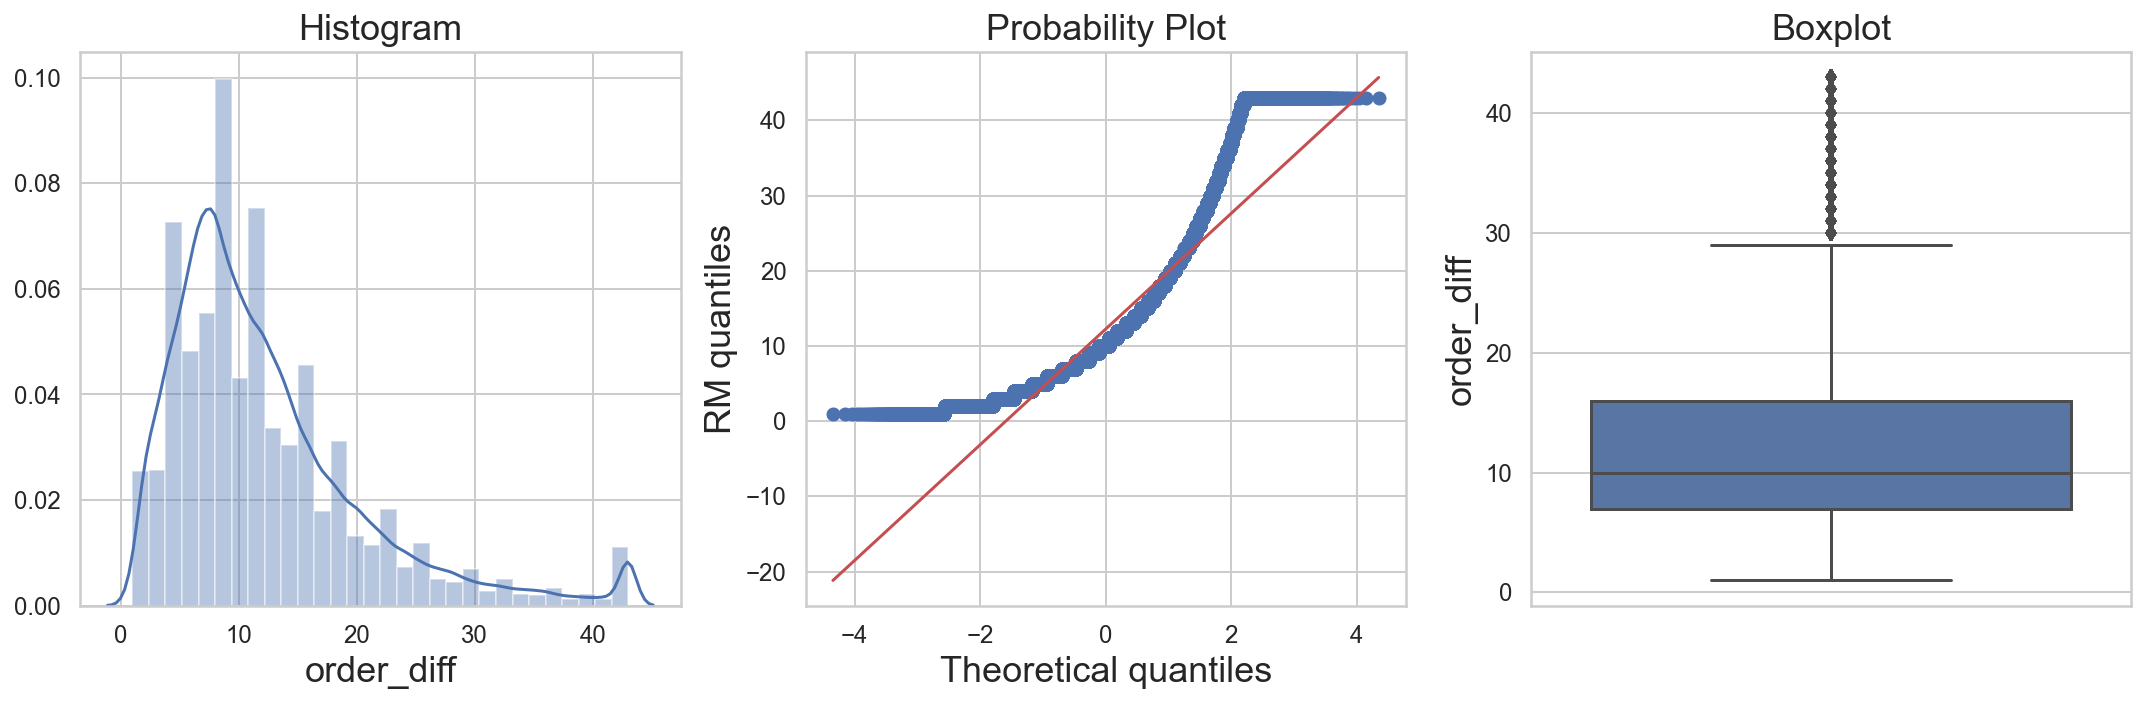

In [17]:
# limiting the order_diff range with the outlier boundaries
df['order_diff'] = np.where(df['order_diff'] > order_diff_upper_limit, int(order_diff_upper_limit), df['order_diff'])

diagnostic_plots(df, 'order_diff')

### Customer Buying Behaviour
The following charts analyse the buying behaviour of the customers by combining the purchase prices with the time of purchase. 

In [18]:
df['price'].describe()

count    100645.000000
mean        108.706165
std          99.233569
min           0.850000
25%          40.000000
50%          78.000000
75%         139.000000
max         436.000000
Name: price, dtype: float64

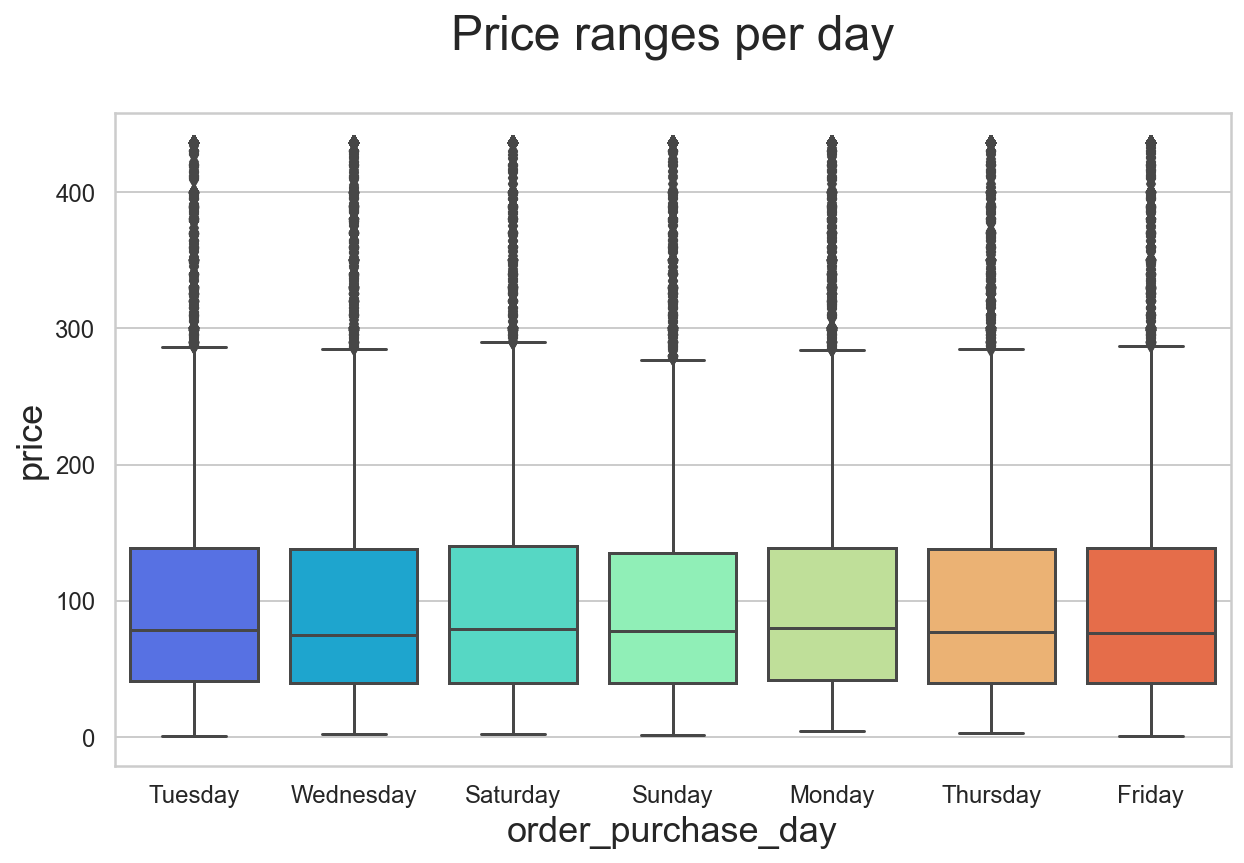

In [19]:
plt.figure(figsize=(10,6))
sns.boxplot(x='order_purchase_day', y='price', 
            data=df,
            palette='rainbow')
plt.title('Price ranges per day\n', fontsize=24)
plt.show();

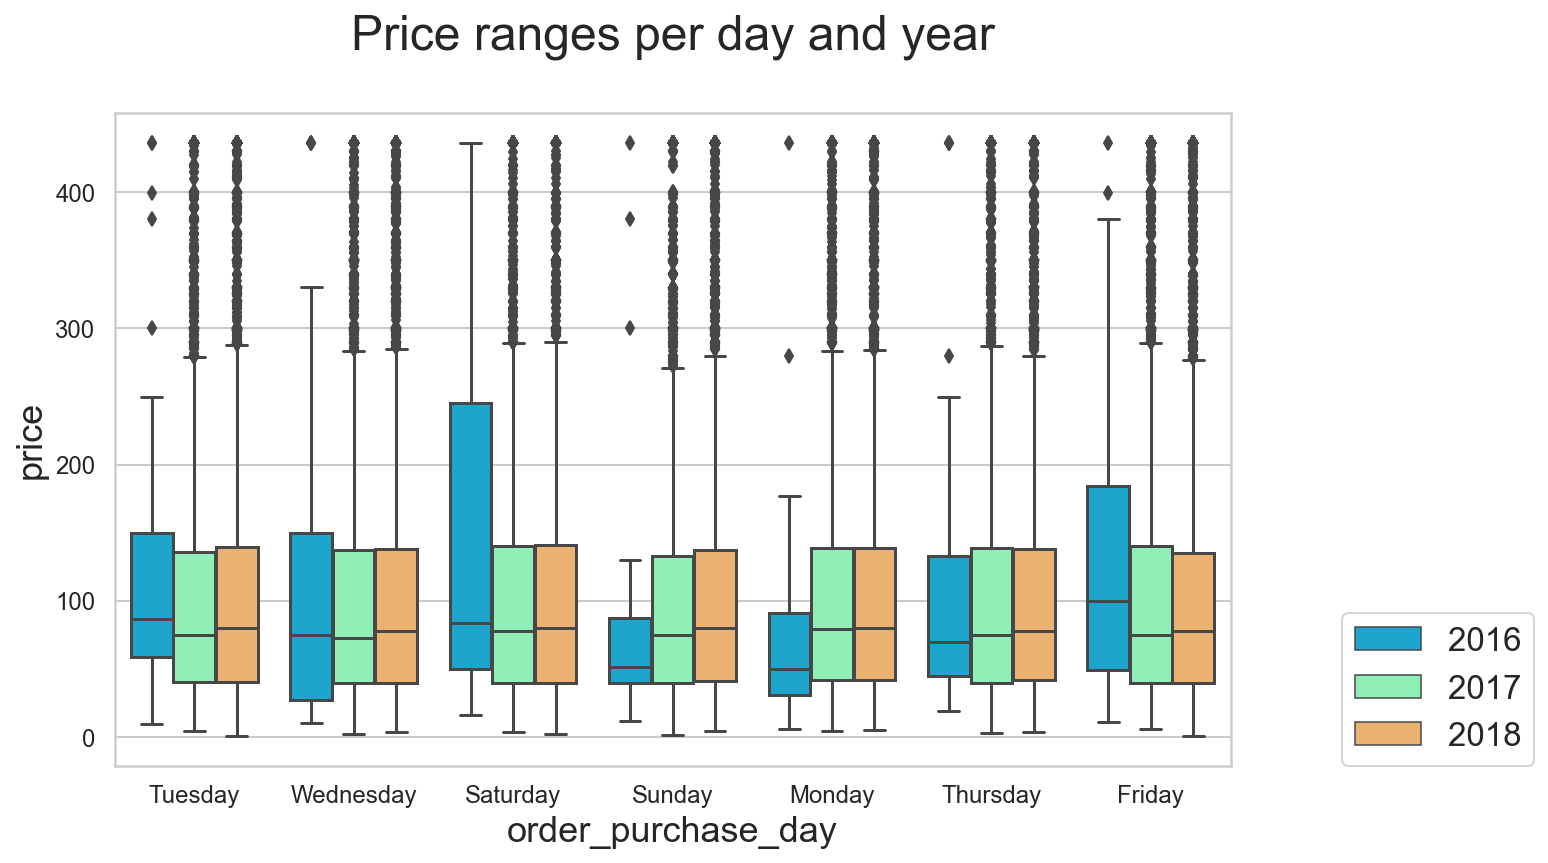

In [20]:
plt.figure(figsize=(10,6))
sns.boxplot(x='order_purchase_day', y='price', 
            data=df,
            hue=df['order_purchase_date'].dt.year,
            palette='rainbow')
plt.title('Price ranges per day and year\n', fontsize=24)
plt.legend(loc=[1.1,0])
plt.show();

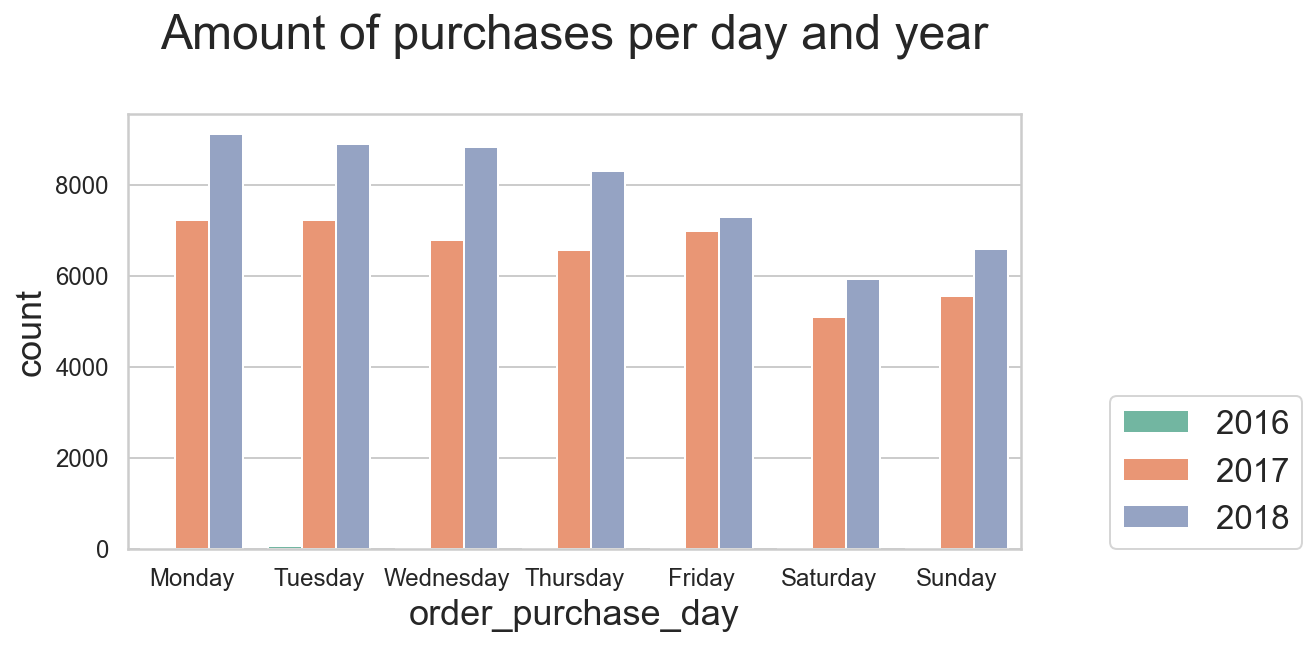

In [21]:
fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(df['order_purchase_day'], order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                                               'Friday', 'Saturday', 'Sunday'], palette='Set2',
             hue=df['order_purchase_date'].dt.year)
ax.set_title('Amount of purchases per day and year\n', fontsize=24)
ax.legend(loc=[1.1,0])
plt.show()

In [22]:
df['order_purchase_date'] = pd.to_datetime(df['order_purchase_date'], format='%Y-%m-%d', errors='coerce')
df_revenue = df[['order_purchase_date', 'payment_value']].copy()
df_revenue = df_revenue.groupby('order_purchase_date').sum()
df_revenue.sort_index(ascending=True, inplace=True)
df_revenue.head()

payment_value
order_purchase_date               
2016-09-15                  134.97
2016-10-03                  559.53
2016-10-04                10042.77
2016-10-05                 7083.98
2016-10-06                 6460.92

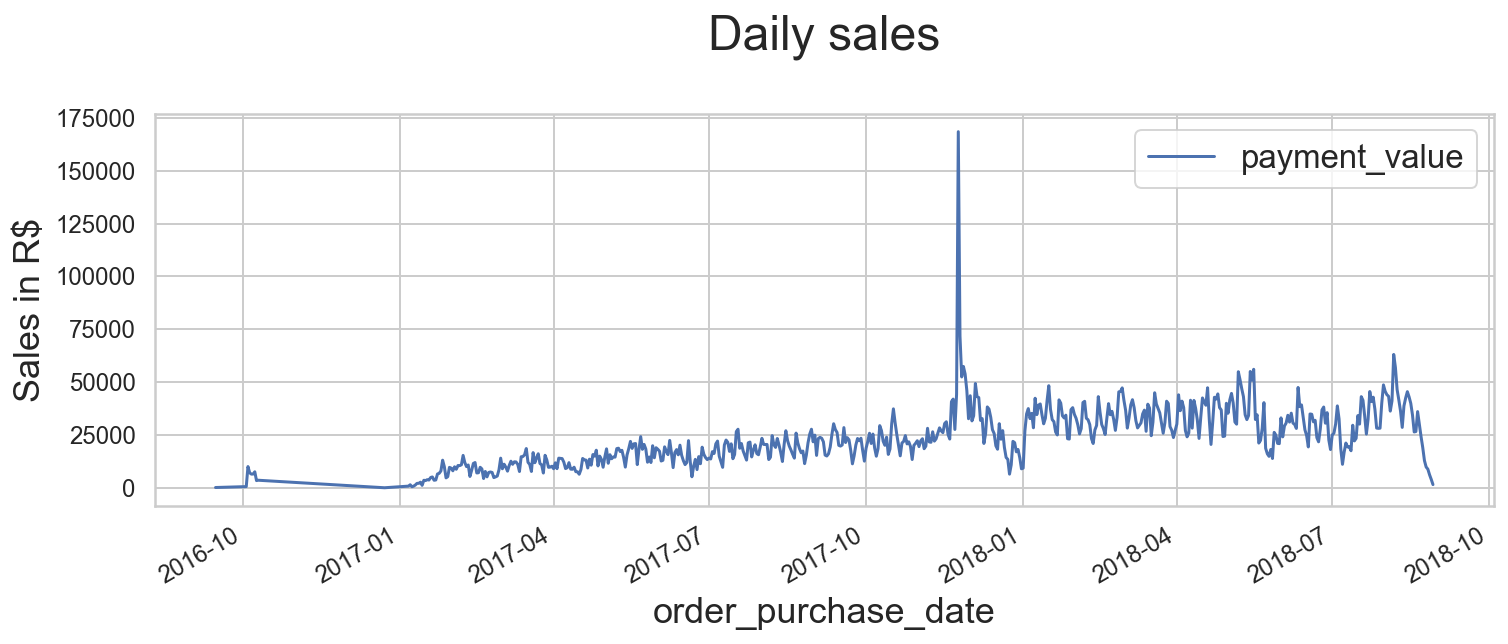

In [23]:
df_revenue.plot(figsize=(12,4));
plt.title('Daily sales\n', fontsize=24)
plt.ylabel('Sales in R$')
plt.show()

In [24]:
# highest sales in a single day
df_revenue.iloc[df_revenue['payment_value'].argmax()]

payment_value    168465.22
Name: 2017-11-24 00:00:00, dtype: float64

In [25]:
most_sales_date = df_revenue.iloc[[df_revenue['payment_value'].argmax()]].index[0]
most_sales_amount = df.loc[df['order_purchase_date'] == most_sales_date].shape[0]
most_sales_revenue = df.loc[df['order_purchase_date'] == most_sales_date]['payment_value'].sum()
print('On {} came in {} orders which gained sales of {} R$.'.format(most_sales_date.date(),
                                                                    most_sales_amount,
                                                                    most_sales_revenue))

On 2017-11-24 came in 1217 orders which gained sales of 168465.22 R$.


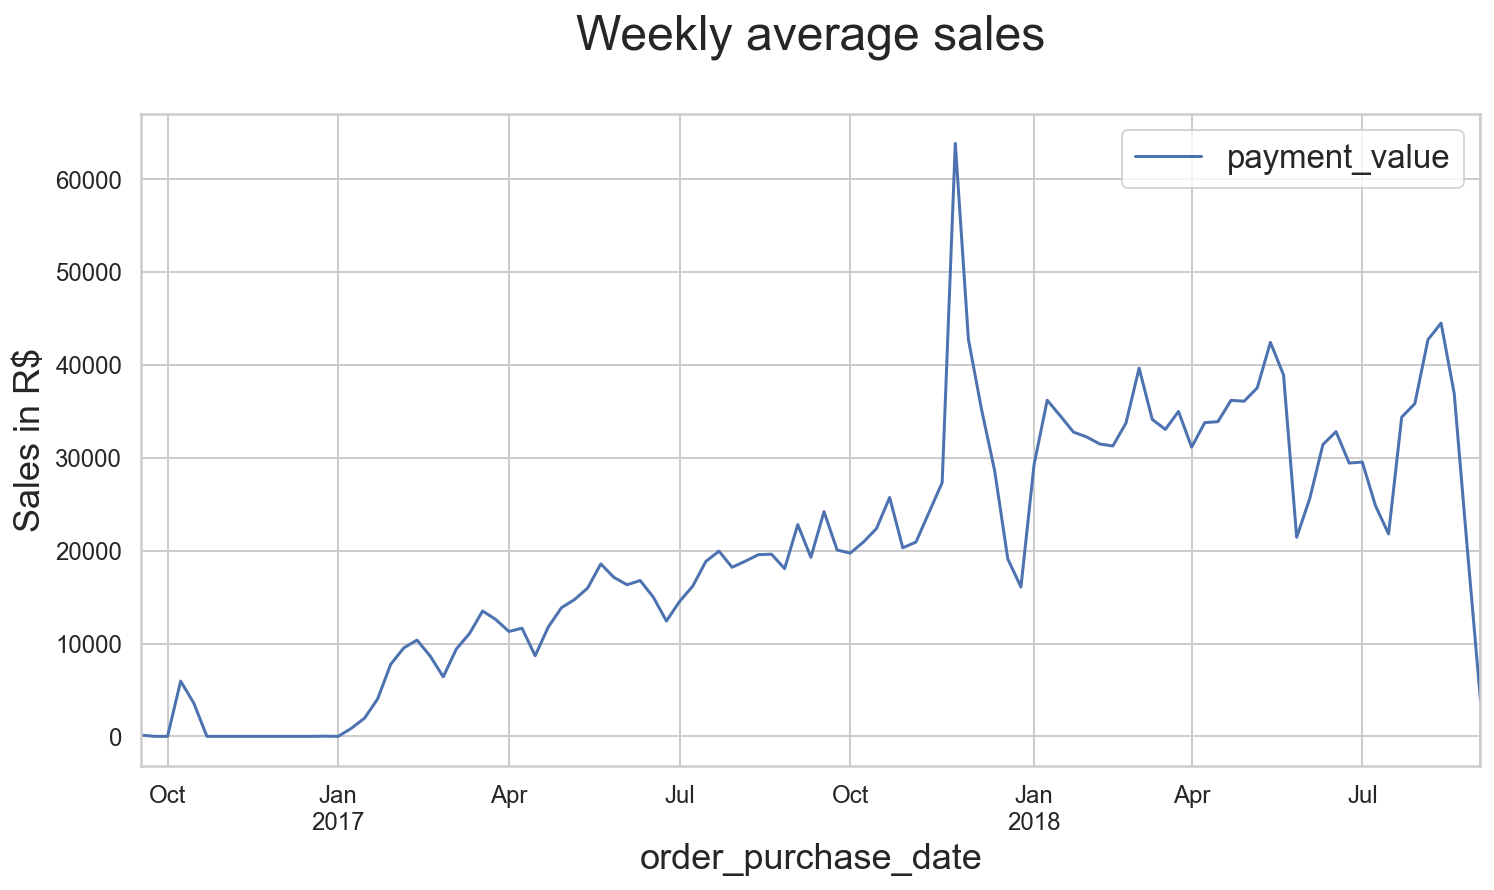

In [26]:
# weekly average sales
df_revenue.resample('W').mean().replace(np.nan, 0).plot(figsize=(12,6))
plt.ylabel('Sales in R$')
plt.title('Weekly average sales\n', fontsize=24)
plt.show()

Investigating if review scores follow a certain pattern compared to prices, freight values, product weights or to delivery time. It exists a trend to worse reviews when the delivery time exceeds around 20 days. 

<Figure size 1008x1008 with 0 Axes>

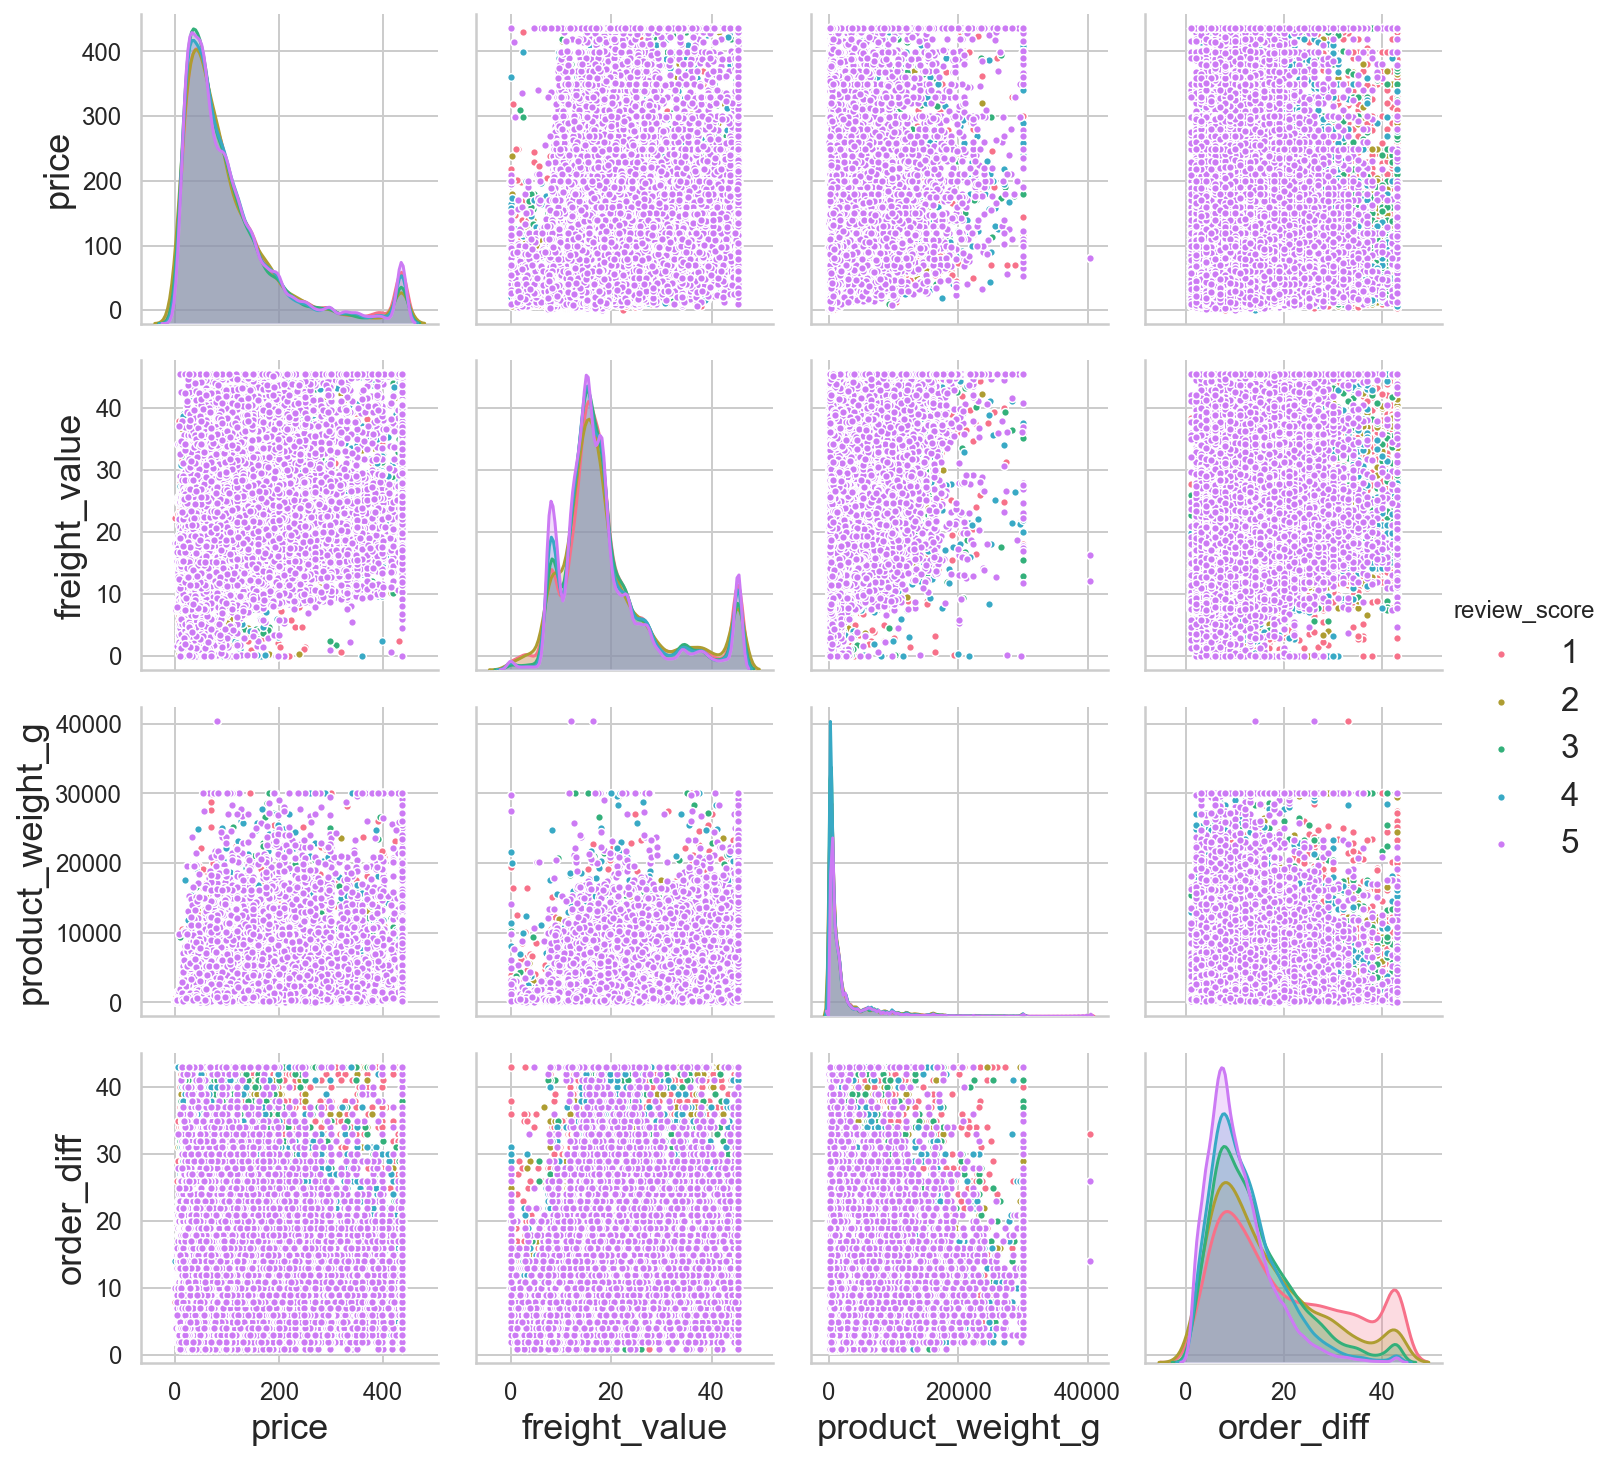

In [27]:
df_pairplot = df[['price', 'freight_value', 'product_weight_g', 'review_score', 'order_diff']]

plt.figure(figsize=(14,14))
sns.pairplot(df_pairplot, hue='review_score', palette='husl', plot_kws={'s': 15})
plt.show()

In [28]:
# investigating when customers are ordering the most
day_hour_revenue = df.groupby(by=['order_purchase_day', 'order_purchase_time'])['payment_value'].sum().unstack()
day_hour_revenue

order_purchase_time        0         1         2        3        4        5   \
order_purchase_day                                                             
Friday               34639.91  41063.36  18212.14  5688.68  6662.92  2440.11   
Monday               28057.95  28469.26  10840.58  6279.90  4357.10  1891.46   
Saturday             28372.06  29945.87  11002.66  6155.80  2959.88  3228.47   
Sunday               25052.62  24600.97  22549.58  7655.09  4121.33  4104.72   
Thursday             30290.84  35345.06  15279.93  7064.31  6188.45  2979.29   
Tuesday              25734.45  31702.73  16309.84  5125.41  4828.59  2967.53   
Wednesday            35684.38  36934.41  15234.84  6267.24  3380.01  2175.03   

order_purchase_time       6         7         8          9          10  \
order_purchase_day                                                       
Friday               8437.37  20305.04  50066.39   86480.26  129480.56   
Monday               4129.77  15666.75  36654.91  110336.84  124102.82   
Saturday             6339.87  13077.79  25029.38   49726.04   86012.92   
Sunday               2042.42   6999.70  25709.22   36031.58   70641.97   
Thursday             5579.17  17352.22  45644.25  104853.69  123465.56   
Tuesday              5268.87  19234.26  44131.41  101032.72  137464.97   
Wednesday            6627.10  17178.93  48871.07   97381.22  137187.80   

order_purchase_time         11         12         13         14         15  \
order_purchase_day                                                           
Friday               146092.27  139782.34  127834.74  139033.19  145749.84   
Monday               149978.93  145894.98  144903.64  158656.43  159687.61   
Saturday              89105.84  111847.55  110166.08  102959.40  114109.98   
Sunday                84838.74   98320.95   94116.08   98312.67   95012.21   
Thursday             140102.78  144998.67  136479.68  137122.96  142055.81   
Tuesday              151012.38  134631.43  144689.36  177028.12  161923.02   
Wednesday            153314.85  146448.29  136072.30  148986.94  153243.52   

order_purchase_time         16         17         18         19         20  \
order_purchase_day                                                           
Friday               142520.40  146717.11  106080.26  109768.97  107629.25   
Monday               156613.29  149215.58  143677.60  139351.55  141432.96   
Saturday             102690.58   96778.39  105483.72  108256.67  104972.64   
Sunday               106570.93  104841.99  118491.22  130993.09  136600.03   
Thursday             146737.35  144386.78  117787.48  121879.26  118580.74   
Tuesday              170443.68  156875.14  133269.50  129839.34  129955.83   
Wednesday            146900.00  143202.34  135331.21  114910.55  122282.70   

order_purchase_time         21         22         23        24  
order_purchase_day                                              
Friday               106215.85  105381.71   83547.19  33522.09  
Monday               154857.43  161102.93  136555.46  36745.27  
Saturday             103343.33   93117.50   64768.84  23489.25  
Sunday               128033.85  123339.30  103015.18  34762.63  
Thursday             122076.90  126349.20   99159.22  29177.98  
Tuesday              137139.05  157650.82  125616.59  42363.84  
Wednesday            131637.58  130020.62  109016.42  33850.21

Customers place the most orders during the week and between 10 AM and 5 PM. But on Monday and Tuesday 10 PM is popular as well. The most orders were done on Tuesday at around 2 PM.

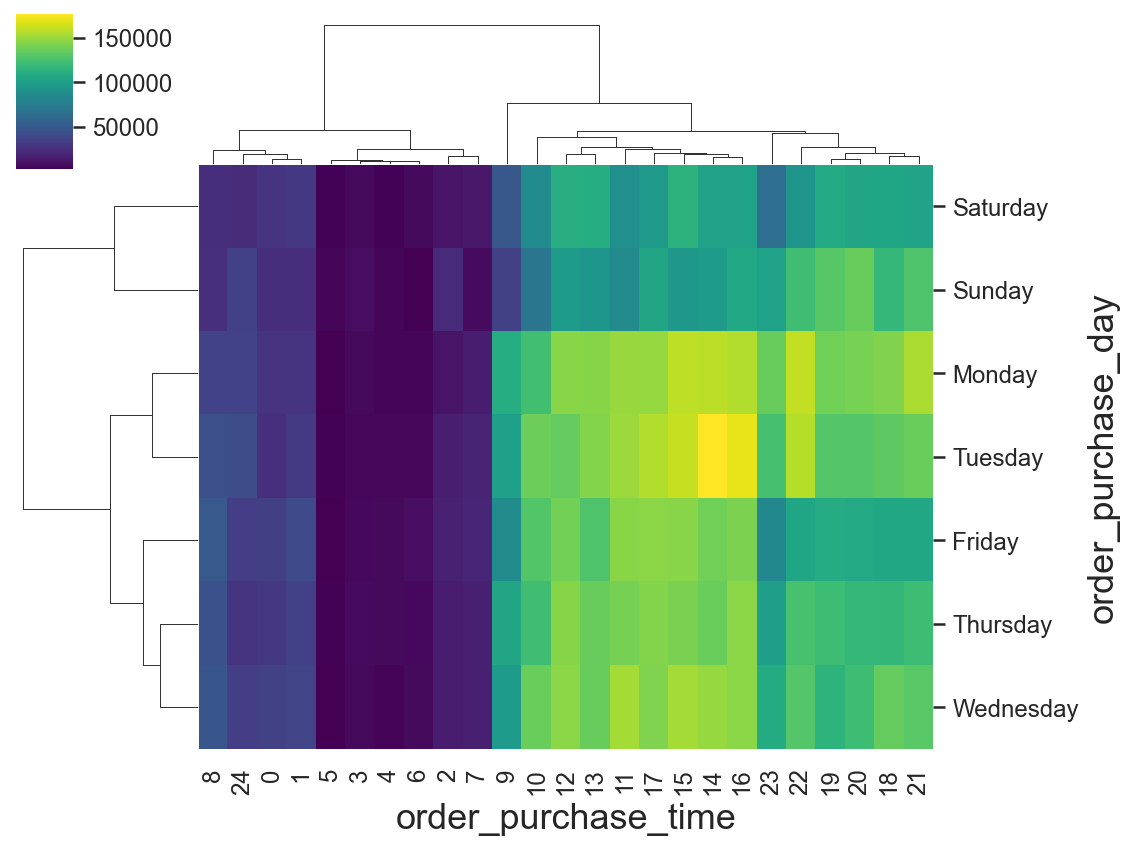

In [29]:
sns.clustermap(day_hour_revenue, cmap='viridis', figsize=(8,6));

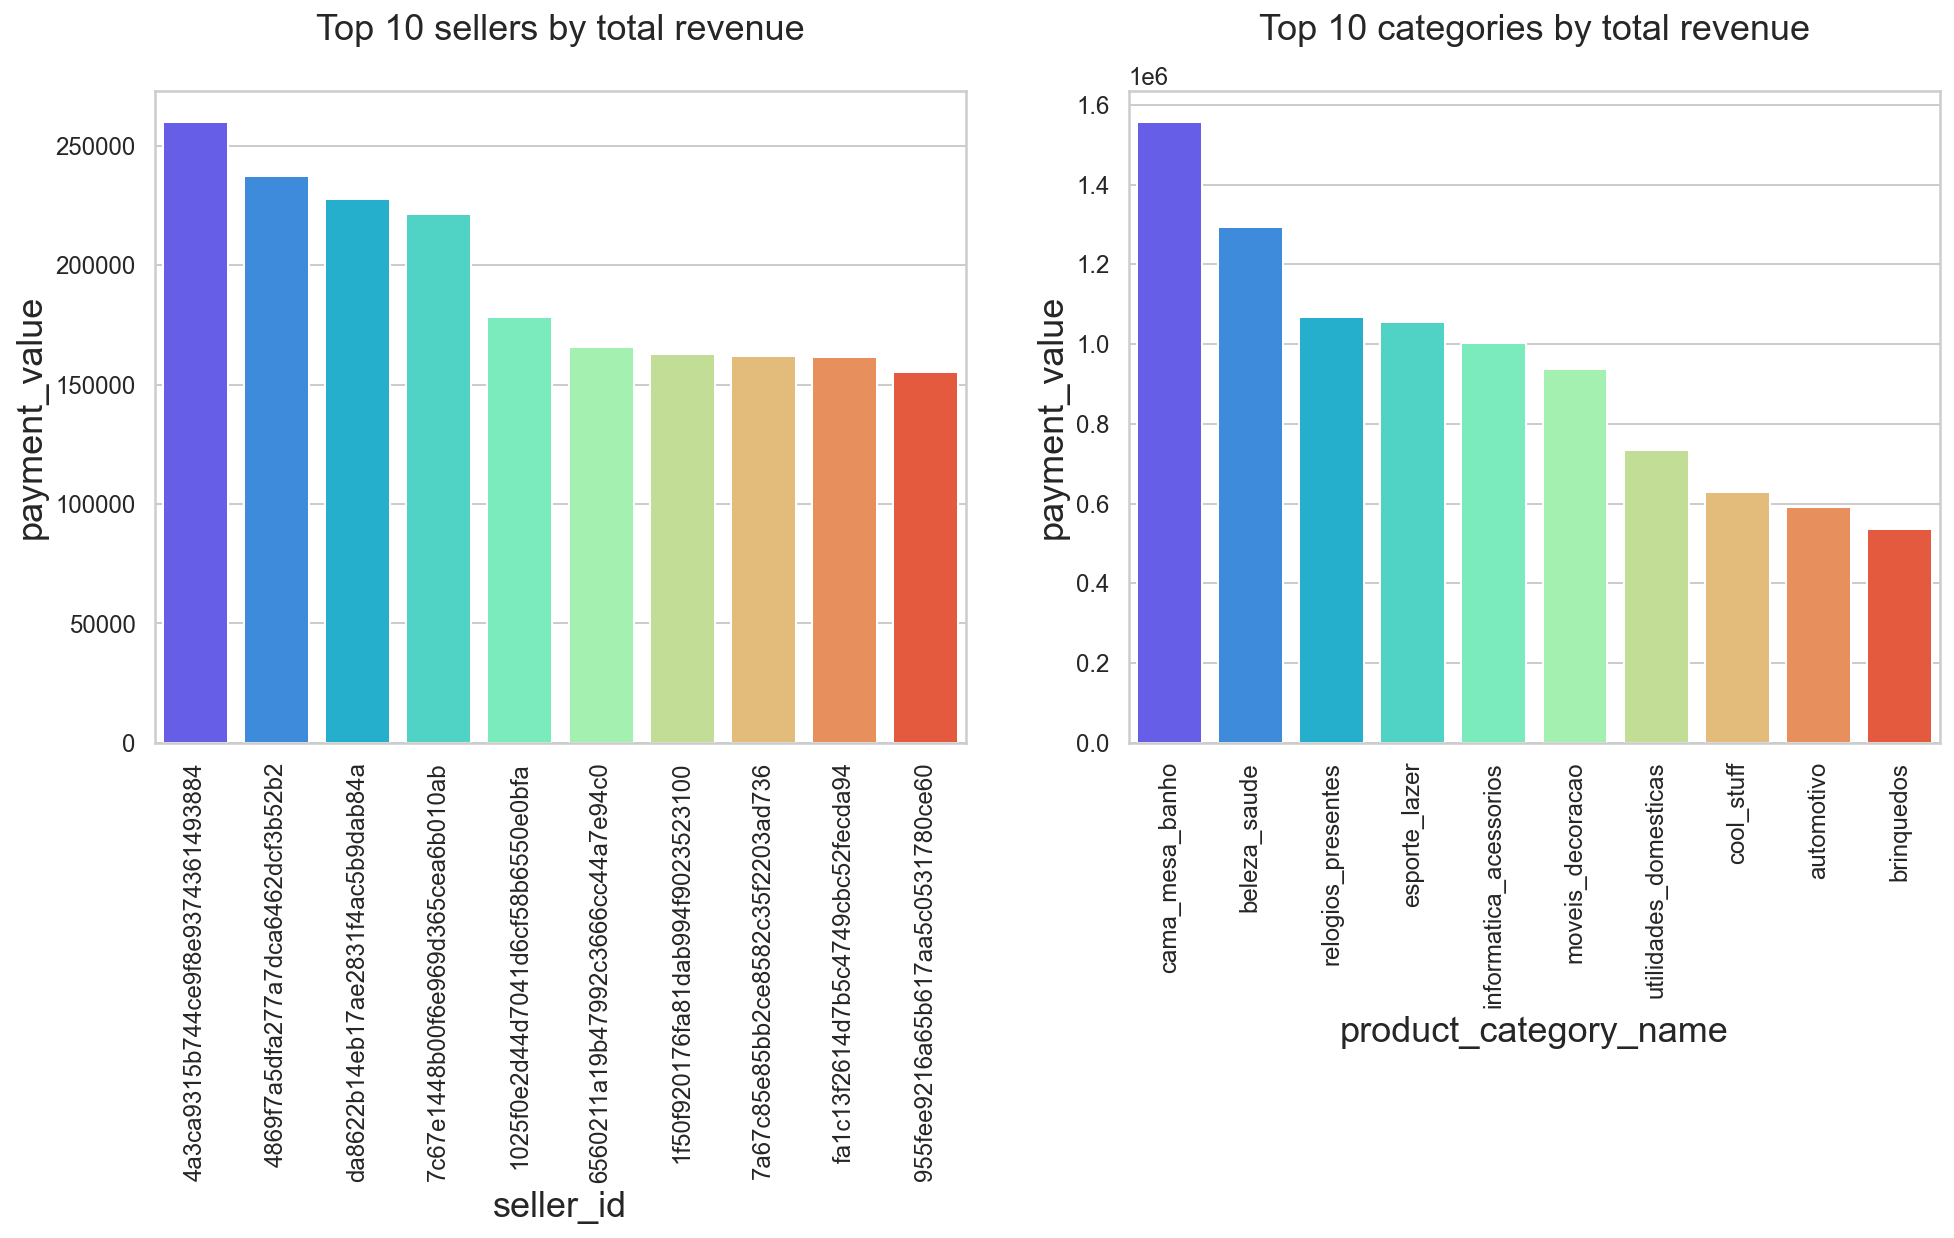

In [30]:
# depicting the best sellers and categories by sales
best_sellers = df.groupby('seller_id')[['payment_value']].sum().sort_values(by='payment_value', ascending=False)[:10]
best_categories = df.groupby('product_category_name')[['payment_value']].sum().sort_values(by='payment_value', 
                                                                                           ascending=False)[:10]

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(x=best_sellers.index, y='payment_value', data=best_sellers, palette='rainbow', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_title('Top 10 sellers by total revenue\n')

sns.barplot(x=best_categories.index, y='payment_value', data=best_categories, palette='rainbow', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_title('Top 10 categories by total revenue\n')

plt.show()

### Review Score
This section is investigating the distribution of the review score over the whole billing period and over the individual years. Furthermore, the review score is compared with the products.

In [31]:
df['review_score'].value_counts()

5    58631
4    19514
1    10754
3     8445
2     3301
Name: review_score, dtype: int64

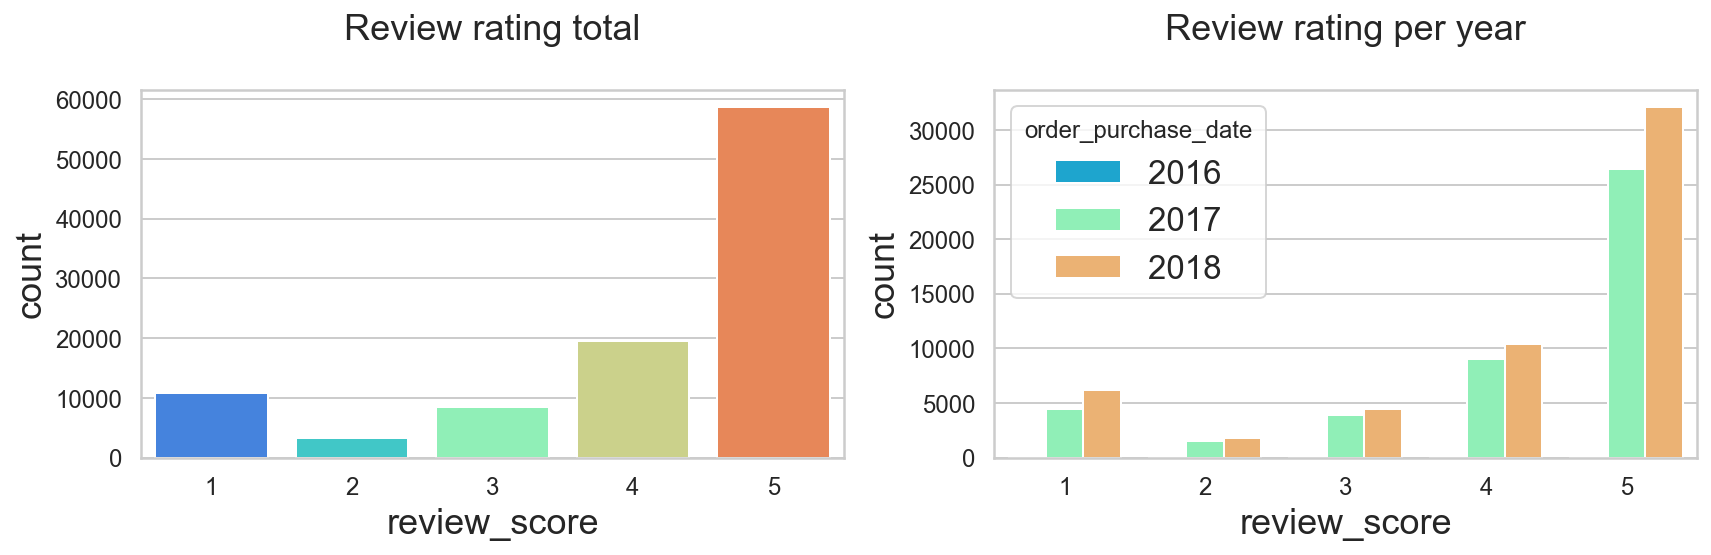

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.countplot(df['review_score'], palette='rainbow', ax=ax[0])
ax[0].set_title('Review rating total\n')
sns.countplot(df['review_score'], palette='rainbow', hue=df['order_purchase_date'].dt.year, ax=ax[1])
ax[1].set_title('Review rating per year\n')
plt.tight_layout()
plt.show()

In [33]:
print(f"Amount of unique products: {df[['product_id']].nunique()[0]}")

Amount of unique products: 32216


The next two charts are showing the products with the most lowest and highest review scores without taking any normalization into account. 

In [34]:
product_scores = df.loc[df['review_score'] == 1].groupby('product_id')[['order_id']] \
                                                .count().sort_values(by='order_id', ascending=False)
product_scores.rename(columns={'order_id': 'rating_1'}, inplace=True)

for rate in range(2,6):
    product_scores[f'rating_{rate}'] = df.loc[df['review_score'] == rate].groupby('product_id')[['order_id']] \
                                                                         .count()

In [35]:
product_scores.fillna(value=0, inplace=True)
worst_ratings = product_scores.iloc[:5,:]
worst_ratings

rating_1  rating_2  rating_3  rating_4  \
product_id                                                                 
99a4788cb24856965c36a24e339b6058        58      18.0      63.0      95.0   
53759a2ecddad2bb87a079a1f1519f73        44      10.0      23.0      45.0   
422879e10f46682990de24d770e7f83d        41      11.0      23.0      65.0   
e53e557d5a159f5aa2c5e995dfdf244b        41       6.0      13.0      22.0   
368c6c730842d78016ad823897a372db        34       8.0      19.0      59.0   

                                  rating_5  
product_id                                  
99a4788cb24856965c36a24e339b6058     223.0  
53759a2ecddad2bb87a079a1f1519f73     167.0  
422879e10f46682990de24d770e7f83d     213.0  
e53e557d5a159f5aa2c5e995dfdf244b      76.0  
368c6c730842d78016ad823897a372db     171.0

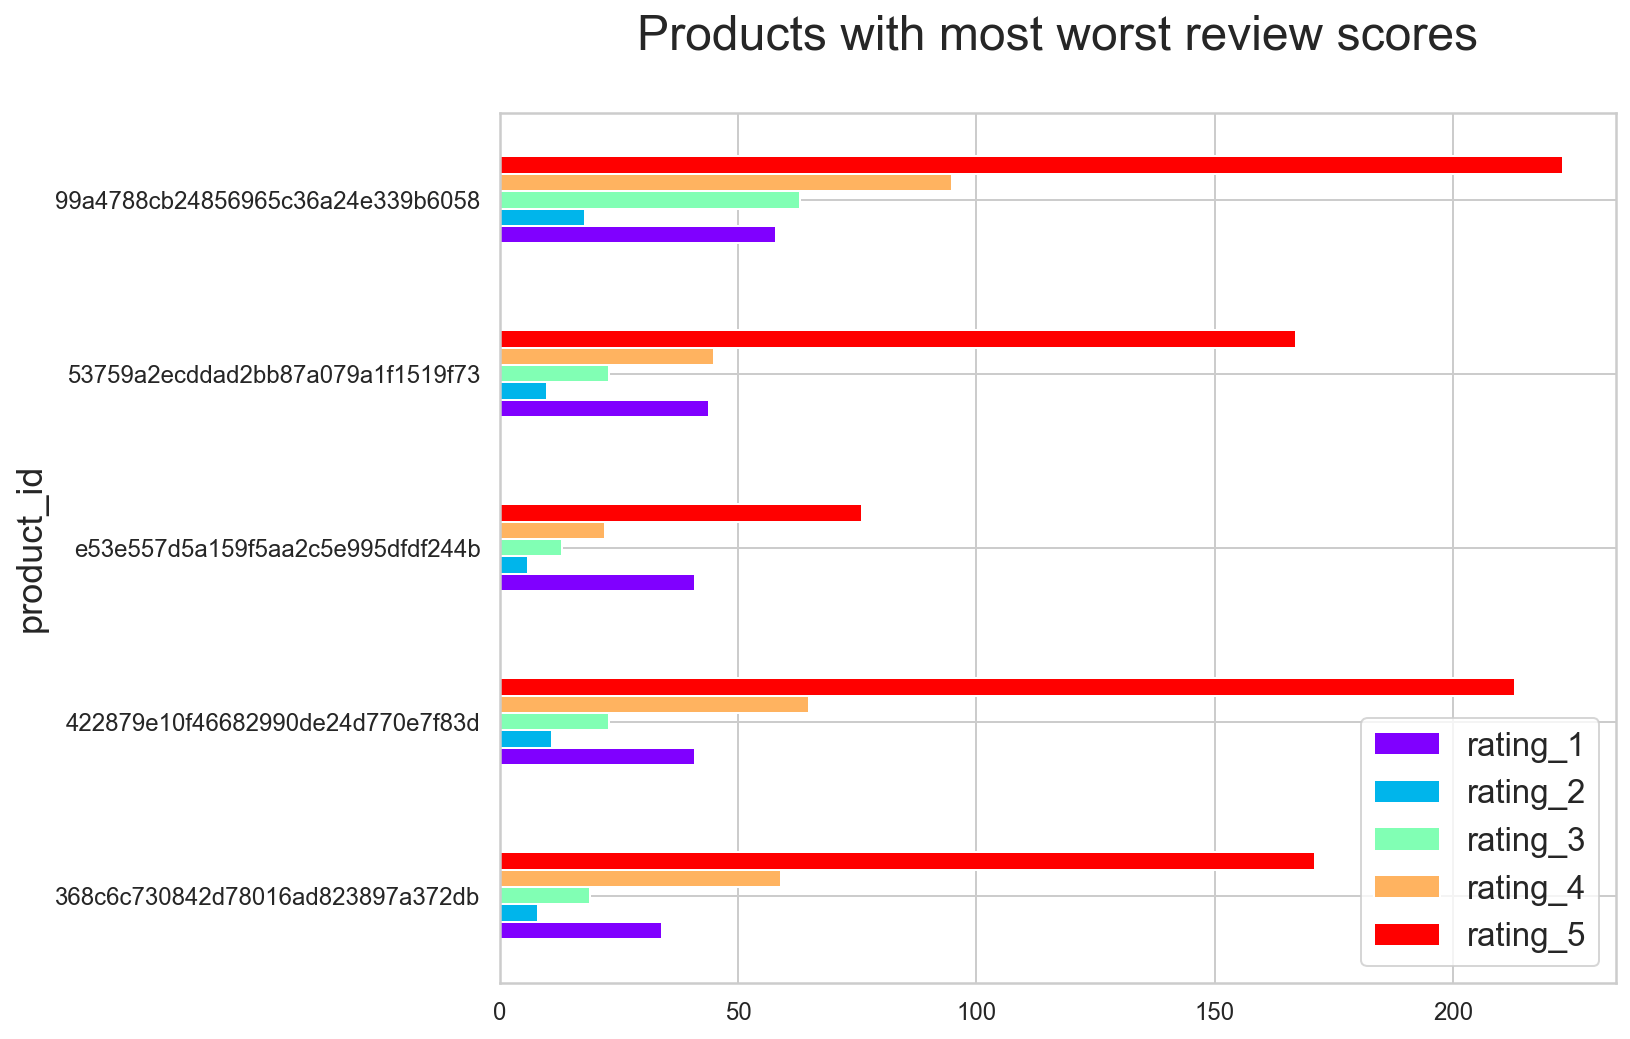

In [36]:
# most worst review scores
worst_ratings.sort_values(by='rating_1', ascending=True).plot(kind='barh', figsize=(10, 8), cmap='rainbow')
plt.title('Products with most worst review scores\n', fontsize=24)
plt.show()

In [37]:
best_ratings = product_scores.sort_values(by='rating_5', ascending=False).iloc[:5,:]
best_ratings

rating_1  rating_2  rating_3  rating_4  \
product_id                                                                 
aca2eb7d00ea1a7b8ebd4e68314663af        32      17.0      46.0     102.0   
99a4788cb24856965c36a24e339b6058        58      18.0      63.0      95.0   
422879e10f46682990de24d770e7f83d        41      11.0      23.0      65.0   
d1c427060a0f73f6b889a5c7c61f2ac4        25       3.0      19.0      69.0   
389d119b48cf3043d311335e499d9c6b        30      11.0      23.0      51.0   

                                  rating_5  
product_id                                  
aca2eb7d00ea1a7b8ebd4e68314663af     228.0  
99a4788cb24856965c36a24e339b6058     223.0  
422879e10f46682990de24d770e7f83d     213.0  
d1c427060a0f73f6b889a5c7c61f2ac4     197.0  
389d119b48cf3043d311335e499d9c6b     194.0

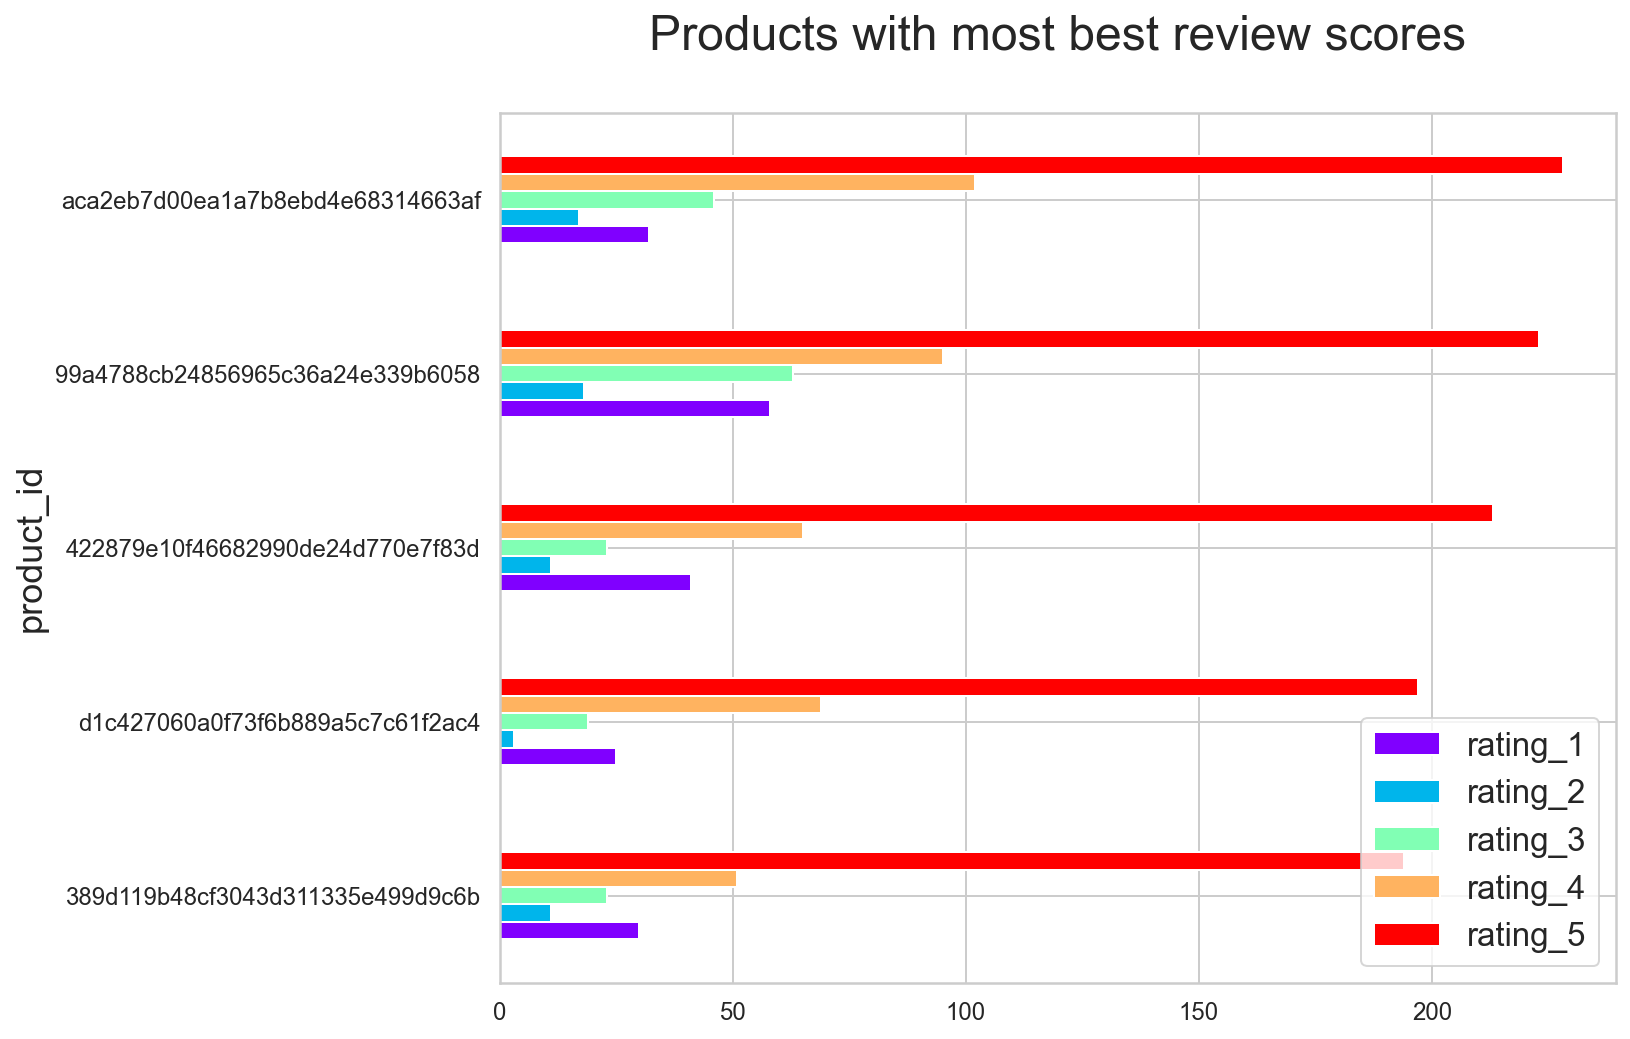

In [38]:
# most best review scores
best_ratings.sort_values(by='rating_5', ascending=True).plot(kind='barh', figsize=(10, 8), cmap='rainbow')
plt.title('Products with most best review scores\n', fontsize=24)
plt.show()

In [39]:
# review average ratings with amount of reviews
review_ratings = df.groupby('product_id')['review_score'].agg([('rating_counts', 'count'),
                                                               ('rating_mean', np.mean)])
review_ratings.head()

rating_counts  rating_mean
product_id                                                  
00066f42aeeb9f3007548bb9d3f33c38              1          5.0
00088930e925c41fd95ebfe695fd2655              1          4.0
0009406fd7479715e4bef61dd91f2462              1          1.0
000b8f95fcb9e0096488278317764d19              2          5.0
000d9be29b5207b54e86aa1b1ac54872              1          5.0

In [40]:
# only taking reviews into account which have over 10 reviews
product_reviews = review_ratings.sort_values(by='rating_counts', ascending=False) \
                                  .loc[review_ratings['rating_counts'] > 10]

product_reviews.sort_values(by='rating_mean', ascending=True)[:10]

rating_counts  rating_mean
product_id                                                  
cd46a885543f0e169a49f1eb25c04e43             28     1.607143
6d2fde7d12bb6ff367dbda120ba8828e             12     1.666667
b36f3c918c91478c4559160022d3f14e             15     1.733333
b1d207586fca400a2370d50a9ba1da98             42     2.023810
89b121bee266dcd25688a1ba72eefb61             57     2.368421
16bf176650a888512655cc94f61860e3             11     2.454545
25c38557cf793876c5abdd5931f922db             38     2.631579
1bfe62f326ac7bec0f5a83c10cfff228             19     2.631579
86ecc269de40ba13205e7beeee12f26f             12     2.666667
1dec4c88c685d5a07bf01dcb0f8bf9f8             35     2.685714

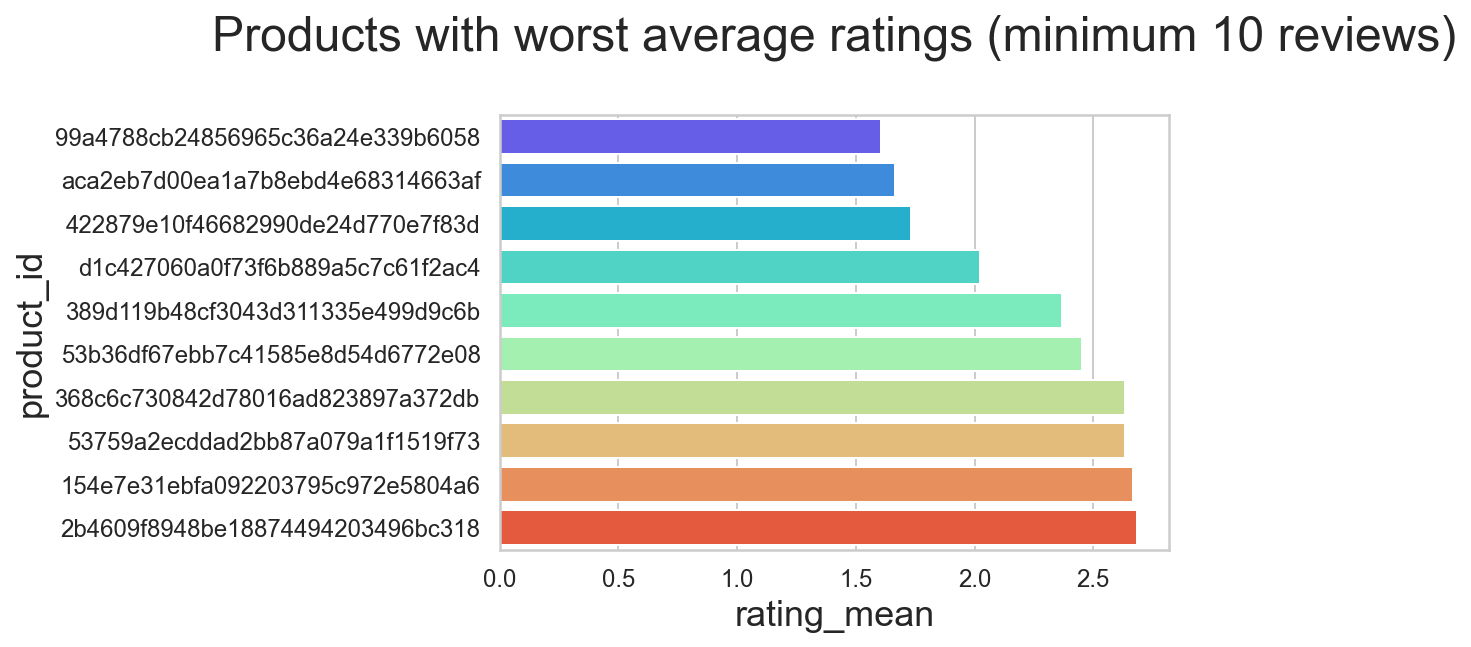

In [41]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(x='rating_mean', y=product_reviews[:10].index, 
            data=product_reviews.sort_values(by='rating_mean', ascending=True)[:10],
            palette='rainbow');
ax.set_title('Products with worst average ratings (minimum 10 reviews)\n', fontsize=24)
plt.show()

### Location
Next part examines the locations of the sellers and customers. The geolocation data don't show the exact location of the sellers due to the limitation of merging the datasets, but it shows in which city they are located.

In [42]:
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [43]:
def create_df_map(kind='customer', points=5000):
    """
    Plotly has issues of showing large data sets. For this reason you can
    limit the amount of data points you want to see by taking a random
    set of the whole dataset with the amount of data points you have 
    defined in the 'points' parameter.
    
    Parameters:
    kind (string): customer or seller
    points (integer): amount of data points
    
    Returns:
    df_map (DataFrame): a DataFrame with a sample set 
    """
    if kind in ['customer', 'seller']:
        lon = 'geolocation_lng_{}'.format(kind)
        lat = 'geolocation_lat_{}'.format(kind)
        txt = '{}_city'.format(kind)
        col = '{}_zip_code_prefix'.format(kind)
        df_map = df[[lon, lat, txt, col]].sample(points).copy()
        return df_map
    else:
        return None

In [44]:
# reducing the amount of customer data points
df_map = create_df_map('customer', 5000)

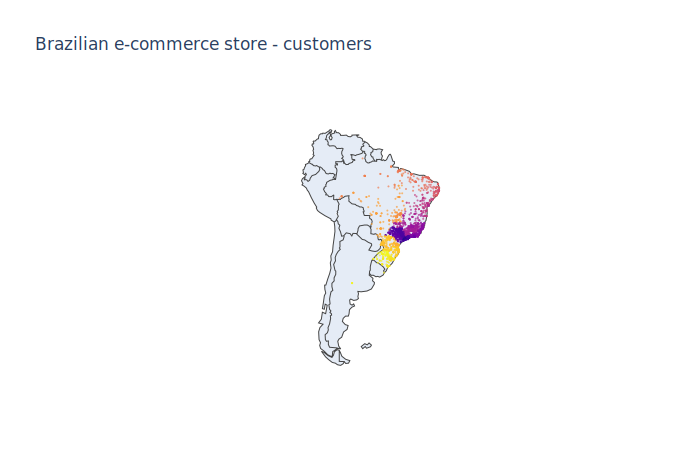

In [45]:
fig = go.Figure(data=go.Scattergeo(
        lon = df_map.iloc[:, 0],
        lat = df_map.iloc[:, 1],
        text = df_map.iloc[:, 2],
        marker = dict(
            color = df_map.iloc[:, 3],
            opacity = 0.7,
            size = 2
            )
        ))

fig.update_layout(
        title = 'Brazilian e-commerce store - customers',
        geo_scope='south america',
    )
fig.show(renderer="svg")  # currently interactive style not working on github

In [46]:
df_map_seller = create_df_map('seller', 3000)

In [47]:
df_map_seller.head()

geolocation_lng_seller  geolocation_lat_seller            seller_city  \
4849               -46.531184              -23.615718            santo andre   
24631              -49.282837              -25.491607               curitiba   
12137              -46.526866              -23.696334            santo andre   
73337              -46.541991              -23.716885  sao bernardo do campo   
61549              -46.448484              -23.540529              sao paulo   

       seller_zip_code_prefix  
4849                     9230  
24631                   81020  
12137                    9180  
73337                    9780  
61549                    8215

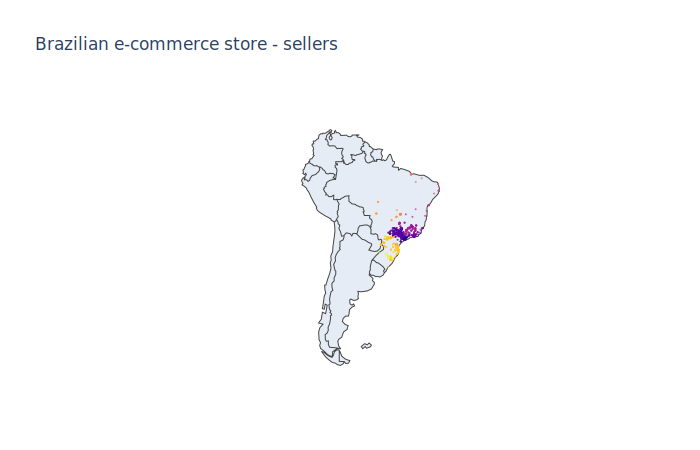

In [48]:
fig = go.Figure(data=go.Scattergeo(
        lon = df_map_seller.iloc[:, 0],
        lat = df_map_seller.iloc[:, 1],
        text = df_map_seller.iloc[:, 2],
        marker = dict(
            color = df_map_seller.iloc[:, 3],
            opacity = 0.7,
            size = 2
            )
        ))

fig.update_layout(
        title = 'Brazilian e-commerce store - sellers',
        geo_scope='south america',
    )
fig.show(renderer="svg")  # currently interactive style not working on github

In [49]:
import geopandas as gpd

In [50]:
# creating the map of brazil (geometry)
fp = './brazlianstates/BRA_adm1.shp'
df_map = gpd.read_file(fp, encoding="utf-8")

In [51]:
df_map.head()

ID_0  ISO  NAME_0  ID_1    NAME_1 HASC_1  CCN_1 CCA_1  TYPE_1 ENGTYPE_1  \
0    33  BRA  Brazil     1      Acre  BR.AC      0  None  Estado     State   
1    33  BRA  Brazil     2   Alagoas  BR.AL      0  None  Estado     State   
2    33  BRA  Brazil     3     Amapá  BR.AP      0  None  Estado     State   
3    33  BRA  Brazil     4  Amazonas  BR.AM      0  None  Estado     State   
4    33  BRA  Brazil     5     Bahia  BR.BA      0  None  Estado     State   

  NL_NAME_1 VARNAME_1                                           geometry  
0      None      None  POLYGON ((-73.33251 -7.32488, -73.27482 -7.350...  
1      None      None  MULTIPOLYGON (((-35.90153 -9.86180, -35.90153 ...  
2      None      None  MULTIPOLYGON (((-50.02403 0.85986, -50.02403 0...  
3      None   Amazone  POLYGON ((-67.32623 2.02968, -67.30118 1.92997...  
4      None      Ba¡a  MULTIPOLYGON (((-38.69708 -17.97903, -38.69708...

In [52]:
#  need only following features for the map
df_map = df_map.filter(['NAME_1', 'geometry'])
# coords is holding the position where the annotations will be shown
df_map['coords'] = df_map['geometry'].apply(lambda x: x.representative_point().coords[:])
df_map['coords'] = [coords[0] for coords in df_map['coords']]

In [53]:
def get_state_abbr(state):
    """
    Renaming the states so they match with the dataframe.
    """
    
    states = {
        'Acre': 'AC',
        'Alagoas': 'AL',
        'Amapá': 'AP',
        'Amazonas': 'AM',
        'Bahia': 'BA',
        'Ceará': 'CE',
        'Distrito Federal': 'DF',
        'Espírito Santo': 'ES',
        'Goiás': 'GO',
        'Maranhão': 'MA',
        'Mato Grosso do Sul': 'MS',
        'Mato Grosso': 'MT',
        'Minas Gerais': 'MG',
        'Pará': 'PA',
        'Paraíba': 'PB',
        'Paraná': 'PR',
        'Pernambuco': 'PE',
        'Piauí': 'PI',
        'Rio de Janeiro': 'RJ',
        'Rio Grande do Norte': 'RN',
        'Rio Grande do Sul': 'RS',
        'Rondônia': 'RO',
        'Roraima': 'RR',
        'São Paulo': 'SP',
        'Santa Catarina': 'SC',
        'Sergipe': 'SE',
        'Tocantins': 'TO'
    }
    if state in states:
        return states[state]
    else:
        return state

In [54]:
df_map['NAME_1'] = df_map['NAME_1'].apply(get_state_abbr)

# payment_value in 1000 $R (Brazil real)
df_revenue = df.groupby(['customer_state'])[['payment_value']].sum() \
               .apply(lambda x: round(x/1000), axis=1).reset_index()
df_merged = pd.merge(df_map, df_revenue, how='inner', left_on='NAME_1', right_on='customer_state') \
              .drop(['customer_state'], axis=1)
df_merged.head(2)

NAME_1                                           geometry  \
0     AC  POLYGON ((-73.33251 -7.32488, -73.27482 -7.350...   
1     AL  MULTIPOLYGON (((-35.90153 -9.86180, -35.90153 ...   

                                      coords  payment_value  
0    (-70.69109385249948, -9.13325929641718)           17.0  
1  (-36.683728766578014, -9.658471584320012)           77.0

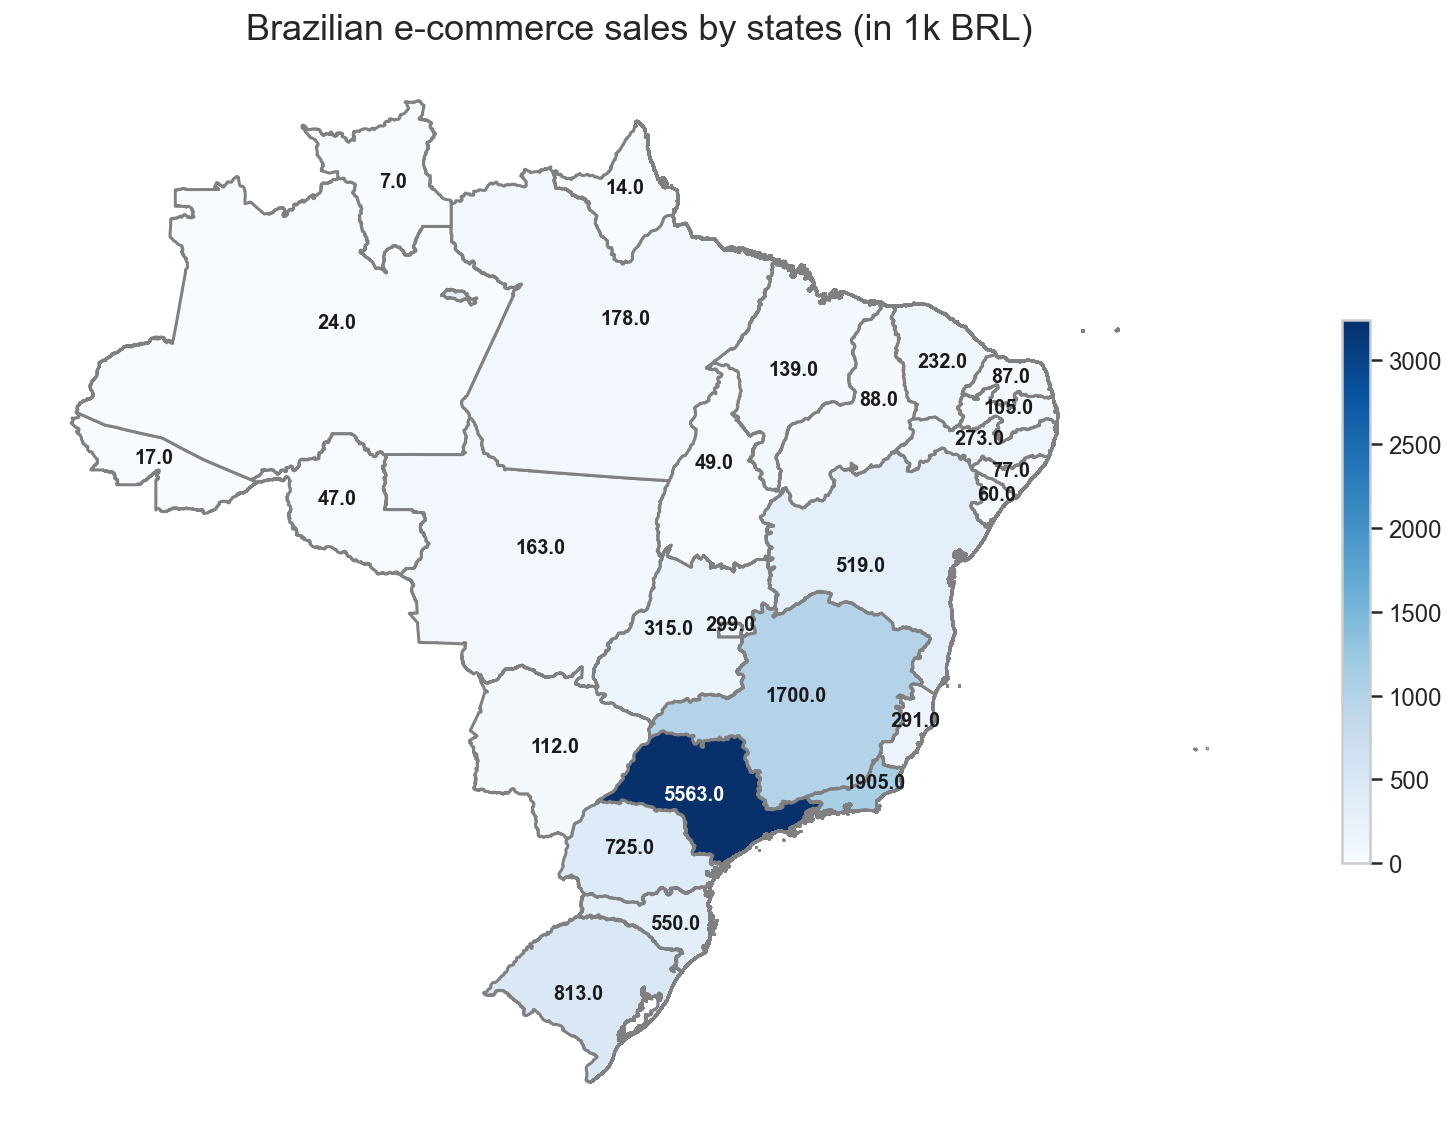

In [55]:
vmin, vmax = df['payment_value'].min(), df['payment_value'].max()
fig, ax = plt.subplots(1, figsize=(14, 10))
ax.axis('off')
ax.set_title('Brazilian e-commerce sales by states (in 1k BRL)', fontdict={'fontsize': 18, 'fontweight': '1'})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, shrink=0.5)
for idx, row in df_merged.iterrows():
    if df_merged['payment_value'].max() == row['payment_value']:
        color = 'white'
    else:
        color = 'k'
    plt.annotate(s=row['payment_value'], xy=row['coords'], horizontalalignment='center', 
                 color=color, fontsize='10', fontweight=600)
df_merged.plot(column='payment_value', cmap='Blues', ax=ax, edgecolor='grey',
               linewidth=1.5) #, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.show()

### Correlation and Relation
Only around $43\,\%$ of the received reviews contain a review message that's why NLP can't be applied as the unique method to predict the review score. For this purpose, the correlations and relations of the review score to the remaining features are examined. 

In [56]:
columns_id_drop = ['order_id', 'customer_id', 'customer_unique_id', 
                   'review_id', 'payment_value']

columns_geo_drop = ['geolocation_lat_customer', 'geolocation_lng_customer', 
                    'geolocation_lat_seller', 'geolocation_lng_seller', 'customer_zip_code_prefix',
                    'seller_zip_code_prefix']

columns_date_drop = ['order_estimated_delivery_date', 'review_creation_date',
                     'shipping_limit_date', 'order_purchase_date']

df_review = df.drop(columns_id_drop + columns_geo_drop + columns_date_drop + ['delivery_weight'], 
                    axis=1)

In [57]:
# package to calculate the relations between numerical/ categorical and categorical/ categorical features
from dython import nominal

In [58]:
df_review.columns

Index(['customer_city', 'customer_state', 'review_score',
       'review_comment_message', 'payment_sequential', 'payment_type',
       'payment_installments', 'order_item', 'product_id', 'seller_id',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'seller_city', 'seller_state',
       'order_approved_diff', 'order_purchase_day', 'order_purchase_time',
       'carrier_diff', 'order_diff', 'review_time'],
      dtype='object')

In [59]:
df_review.select_dtypes(include='O').columns

Index(['customer_city', 'customer_state', 'review_comment_message',
       'payment_type', 'product_id', 'seller_id', 'product_category_name',
       'seller_city', 'seller_state', 'order_purchase_day'],
      dtype='object')

In [60]:
# calculating correlations and relations
# setting categorical features
df_corr = nominal.compute_associations(df_review, nominal_columns=['customer_city', 'customer_state', 
                                                                   'review_comment_message', 'product_id',
                                                                   'payment_type', 'seller_id', 
                                                                   'product_category_name', 'seller_city',
                                                                   'seller_state', 'order_purchase_day'])

In [61]:
coeff_corr = df_corr['review_score'].abs().sort_values(ascending=False)[1:]
coeff_corr.head(10)

review_comment_message    0.816483
product_id                0.608628
order_diff                0.331740
seller_id                 0.256243
customer_city             0.227655
seller_city               0.141456
product_category_name     0.096713
customer_state            0.090115
order_item                0.083979
payment_installments      0.042648
Name: review_score, dtype: float64

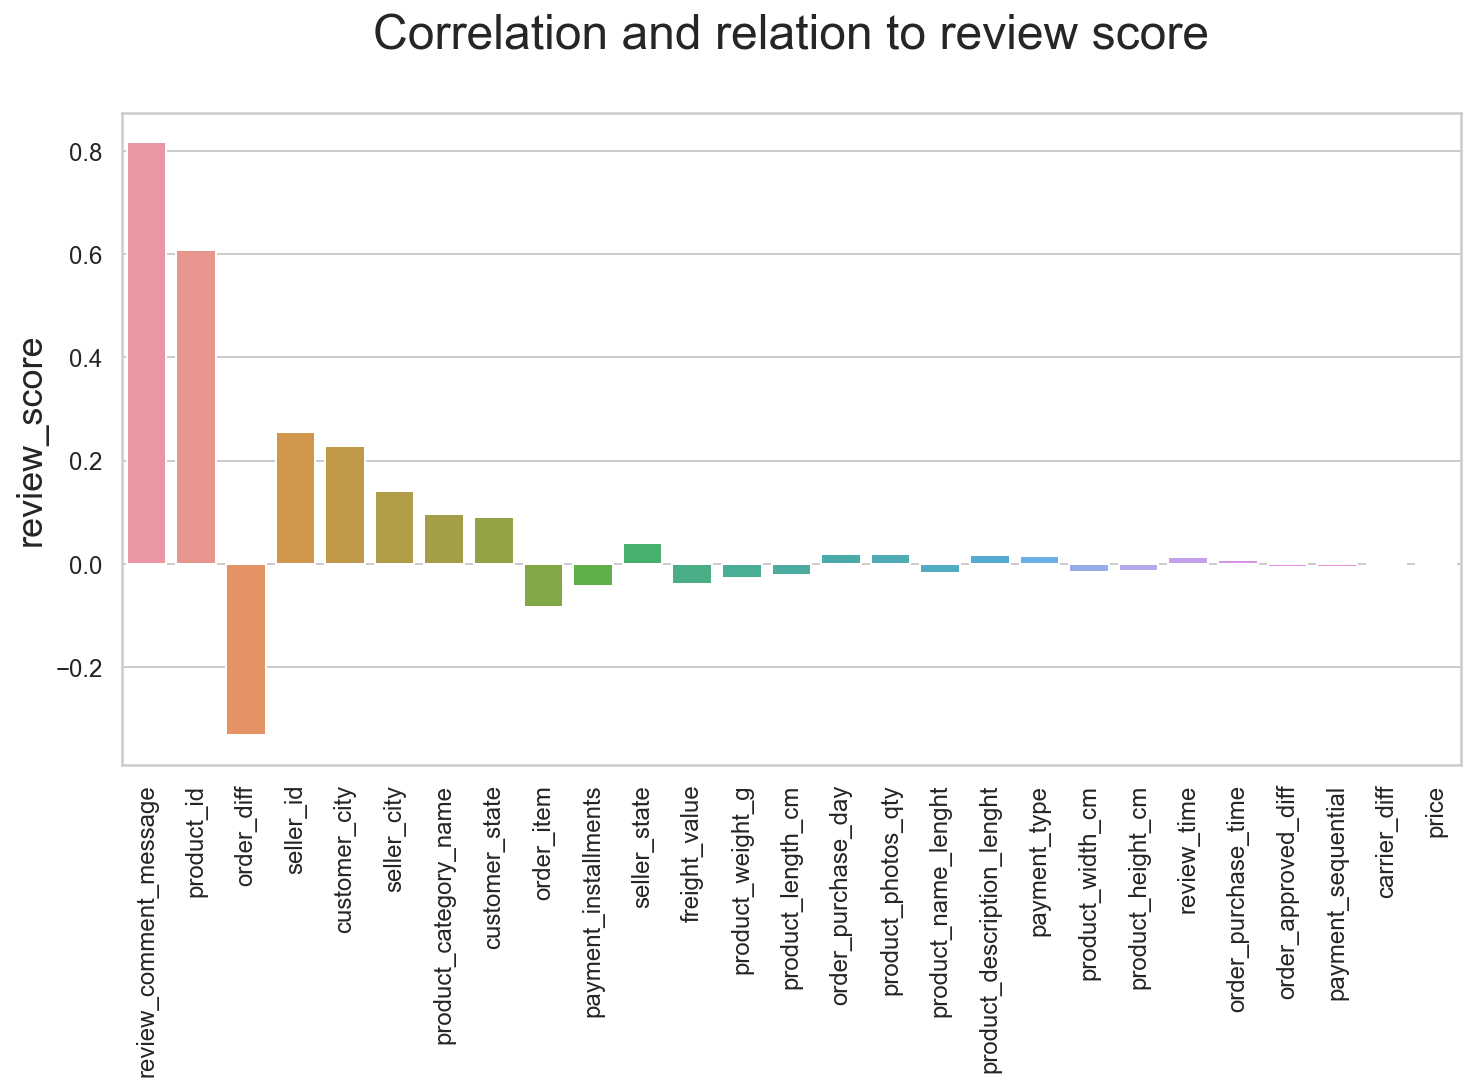

In [62]:
plt.figure(figsize=(12,6))
sns.barplot(df_corr['review_score'].drop('review_score').index, 
            df_corr['review_score'].drop('review_score'), order=coeff_corr.index)
plt.xticks(rotation=90)
plt.title('Correlation and relation to review score\n', fontsize=24)
plt.show()

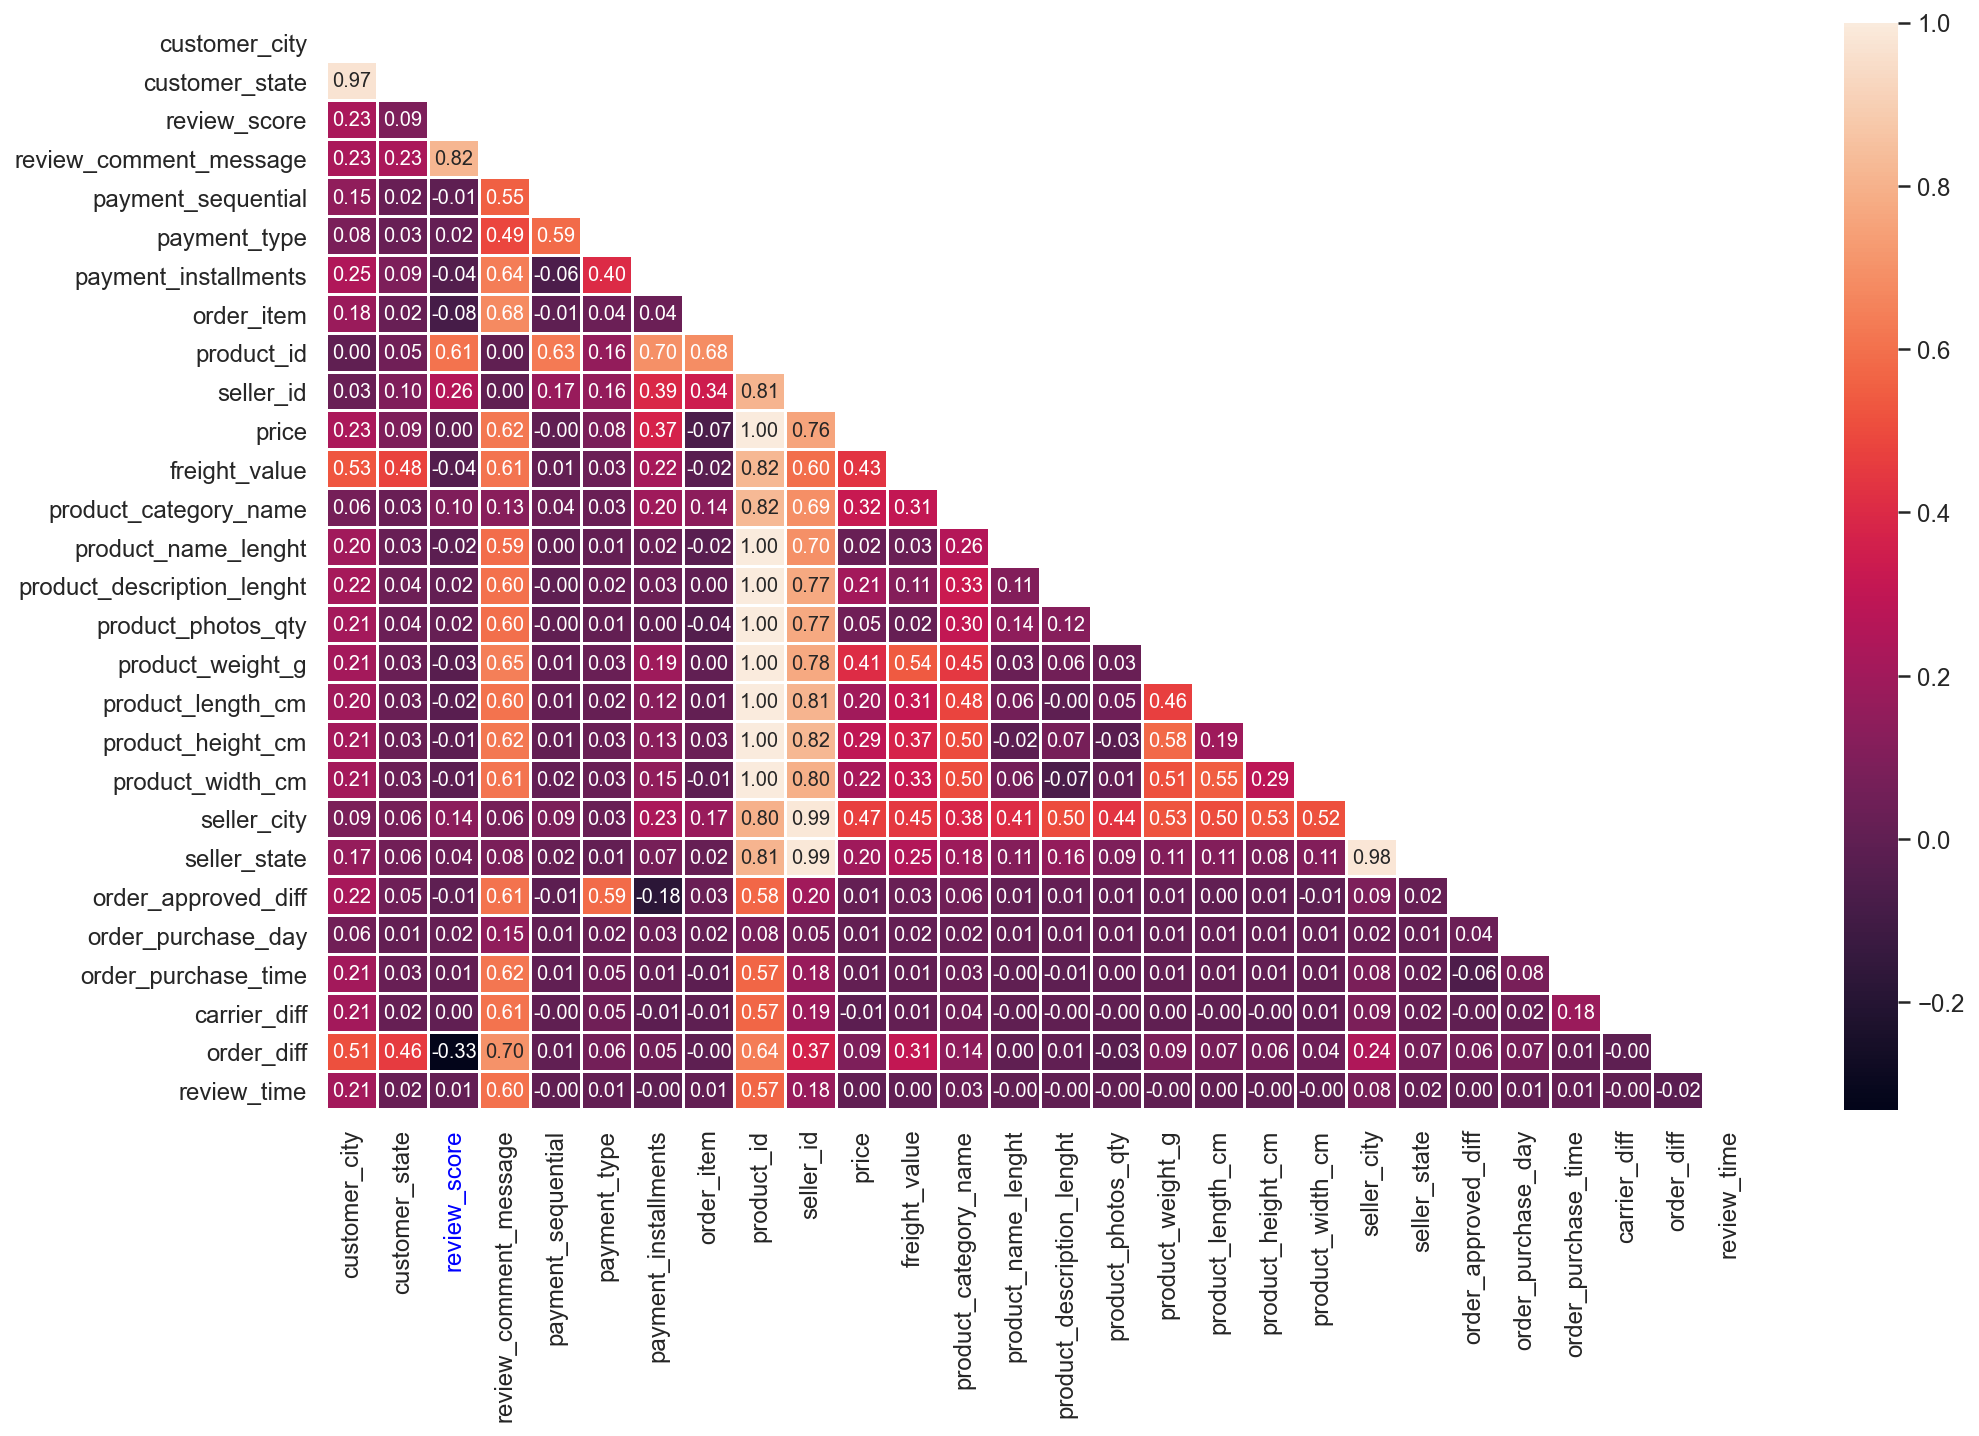

In [63]:
fig, ax = plt.subplots(figsize=(16, 10))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_corr, mask=mask, annot=True, ax=ax,
            linecolor='white',linewidths=1, fmt='.2f', 
            #cbar_kws={'orientation': 'horizontal'}, 
            annot_kws={"size": 10})
ax.set_ylim([df_corr.shape[1], 0])
ax.get_xticklabels()[2].set_color('blue')
#plt.savefig('correlation.png')
plt.show()

In [64]:
if __name__ != '__main__':
    df.to_csv('../resources/Brazilian_retail/ecommerce_review_score.csv', index=False)